In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
from pathlib import Path
import json
from tqdm import tqdm
from math import floor, ceil

In [2]:
# edges = pd.read_csv("../data/edge_list.txt", header=1)

# edges["min"] = edges[["targetPID", "sourcePID"]].min(axis=1)
# edges["max"] = edges[["targetPID", "sourcePID"]].max(axis=1)
# weighted = edges.groupby(["max", "min"])["duration"].sum()
# max_weights = weighted.reset_index().groupby("max")["duration"].sum().to_dict()
# min_weights = weighted.reset_index().groupby("max")["duration"].sum().to_dict()
# weight_dict = {k:min_weights.get(k, 0) + max_weights.get(k, 0) for k in set(max_weights) | set(min_weights)}
# with open("../data/edge_list_weights_dict.json", "w") as dest:
#     json.dump(weight_dict, dest)

In [18]:
with open("../data/edge_list_dict.json") as src:
    node_degrees = json.load(src)
    
with open("../data/edge_list_weights_dict.json") as src:
    node_weights = json.load(src)

In [19]:
list(node_degrees.items())[:10]

[('0', 102),
 ('1', 44),
 ('2', 112),
 ('3', 278),
 ('4', 12),
 ('5', 126),
 ('6', 34),
 ('7', 42),
 ('8', 232),
 ('9', 294)]

In [20]:
list(node_weights.items())[:10]

[('1', 191996),
 ('3', 68880),
 ('5', 42000),
 ('6', 315596),
 ('7', 383992),
 ('9', 133196),
 ('11', 158396),
 ('13', 321596),
 ('15', 193196),
 ('18', 345596)]

In [4]:
node_traits = pd.read_table("/project/biocomplexity/nssac/EpiHiperSynPop/v1.9.0/usa_va_2017_SynPop/va_persontrait_epihiper.txt", low_memory=True, sep=",", usecols=[0,2,3,5], header=1)
node_age = node_traits.set_index("pid")["age"].to_dict()
node_age = node_traits.set_index("pid")["age"].to_dict()

In [5]:
base = Path("/scratch/jho5ze/bionets/epihiper/data/output/")
experiment = "exp5"
scenarios = sorted(glob(str(base / experiment / "*")))
replicates = sorted([i for i in glob(str(base / experiment / scenarios[0] / "*")) if "replicate" in i], key = lambda x: int(x.split("_")[-1]))
len(replicates)

60

In [6]:
def scenario_to_title(scenario):
    scenario = scenario.split("/")[-1]
    scenario = scenario.replace("tau_", "Variant 1: ")
    scenario = scenario.replace("_var2_1.4_seed2p", "")
    scenario = scenario.replace("_5", ", Location: 5")
    scenario = scenario.replace("_seed2t_", ", Emergence Day: ")
#     scenario = scenario.replace("", "")
    return scenario

In [ ]:
# ix=359
# scenario = scenarios[ix // 20].split("/")[-1]
# replicate = replicates[ix % 20].split("/")[-1]

# output = pd.read_csv(base / experiment / scenario / replicate / "output.csv.gz")
# summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")

# node_ids = [int(i) for i in node_degrees.keys()]
# # suscep_degrees = node_degrees.copy()
# state_array = ["S" for i in range(7688058+1)]
# state_dict = {state:[] for state in output.exit_state.unique()}
# state_dict["S"] = node_ids
# dfs = []
# susc_dfs = []
# for tick in tqdm(range(250)):
#     df = output[output.tick == tick]
#     for pid, state in df.set_index("pid")["exit_state"].to_dict().items():
#         prev_state = state_array[pid]
#         state_array[pid] = state
#         state_dict[prev_state].remove(pid)
#         state_dict[state].append(pid)
# #         if prev_state == "S":
# #             del suscep_degrees[str(pid)]
#     ds = []
#     x = pd.DataFrame(state_dict["var1E"], columns=["pid"])
#     x["tick"] = tick
#     x["variant"] = "var1"
#     ds.append(x)
#     x = pd.DataFrame(state_dict["var2E"], columns=["pid"])
#     x["tick"] = tick
#     x["variant"] = "var2"
#     ds.append(x)
#     df = pd.concat(ds)
#     dfs.append(df)
    
# #     x = pd.DataFrame(suscep_degrees.values(), columns=["node_degree"])
# #     x["tick"] = tick
# #     susc_dfs.append(x)
    
# variant_data = pd.concat(dfs)
# variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])

In [23]:
bins = {i:0 for i in range(ceil(max(node_degrees.values()) / 50))}
bins[0]

0

In [11]:
[i for i in range(0, 1272, 200)]

[0, 200, 400, 600, 800, 1000, 1200]

In [40]:
ix=359
scenario = scenarios[ix // 20].split("/")[-1]
replicate = replicates[ix % 20].split("/")[-1]

output = pd.read_csv(base / experiment / scenario / replicate / "output.csv.gz")
summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")

node_ids = [int(i) for i in node_degrees.keys()]
state_array = ["S" for i in range(7688058+1)]
state_dict = {state:[-1 for i in range(7688058+1)] for state in list(output.exit_state.unique()) + ["S"]}
for pid in node_ids:
    state_dict["S"][pid] = pid
dfs = []
susc_dfs = []
for tick in tqdm(range(300)):
    df = output[output.tick == tick]
    for pid, state in df.set_index("pid")["exit_state"].to_dict().items():
        prev_state = state_array[pid]
        state_array[pid] = state
        state_dict[prev_state][pid] = -1 
        state_dict[state][pid] = pid 
    x = pd.DataFrame(list(set(state_dict["var1E"]) - {-1}), columns=["pid"])
    x["tick"] = tick
    x["variant"] = "var1"
    dfs.append(x)
    x = pd.DataFrame(list(set(state_dict["var2E"]) - {-1}), columns=["pid"])
    x["tick"] = tick
    x["variant"] = "var2"
    dfs.append(x)
#     bins = {i:0 for i in range(ceil(max(node_degrees.values()) / 50))}
#     for pid in list(set(state_dict["S"]) - {-1}):
#         bins[node_degrees[str(pid)]//50] += 1
#     x = pd.DataFrame(bins, index=[tick])
# #     x["tick"] = tick
# #     x["variant"] = "var2"
#     susc_dfs.append(x)
#     df = pd.concat(ds)
#     dfs.append(df)
    
#     x = pd.DataFrame(suscep_degrees.values(), columns=["node_degree"])
#     x["tick"] = tick
#     susc_dfs.append(x)
    
variant_data = pd.concat(dfs)
variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])

100%|██████████| 300/300 [00:41<00:00,  7.19it/s]


In [29]:
pd.DataFrame(bins, index=[tick])

0        1        2       3       4       5      6      7     8   \
0  1850067  2524310  1806170  855981  356876  132944  47450  17945  7234   

     9   ...  16  17  18  19  20  21  22  23  24  25  
0  3195  ...  39  29  11   9   5   1   2   1   0   1  

[1 rows x 26 columns]

In [33]:
    
susc_data = pd.concat(susc_dfs)
susc_data
# susc_data["node_degree"] = susc_data.pid.apply(lambda row: node_degrees[str(row)])

0        1        2       3       4       5      6      7     8   \
0   1850067  2524310  1806170  855981  356876  132944  47450  17945  7234   
1   1850063  2524304  1806164  855980  356874  132943  47450  17945  7234   
2   1850056  2524298  1806162  855976  356874  132942  47450  17945  7234   
3   1850049  2524292  1806157  855974  356874  132942  47450  17945  7234   
4   1850041  2524285  1806154  855974  356873  132941  47450  17945  7234   
5   1850036  2524278  1806150  855971  356871  132941  47450  17945  7234   
6   1850033  2524270  1806143  855967  356871  132940  47450  17945  7234   
7   1850028  2524264  1806135  855963  356869  132940  47449  17945  7234   
8   1850027  2524259  1806125  855958  356869  132936  47449  17945  7234   
9   1850021  2524251  1806122  855952  356865  132934  47449  17945  7234   
10  1850021  2524251  1806121  855949  356864  132934  47449  17945  7234   
11  1850021  2524247  1806118  855946  356864  132934  47449  17945  7234   
12  1850021  2524245  1806113  855946  356860  132934  47448  17945  7234   
13  1850018  2524242  1806110  855943  356860  132934  47448  17945  7234   
14  1850018  2524237  1806105  855938  356860  132933  47448  17943  7234   
15  1850018  2524233  1806100  855931  356860  132932  47448  17943  7234   
16  1850017  2524230  1806092  855927  356857  132932  47448  17943  7234   
17  1850017  2524225  1806087  855922  356856  132932  47448  17942  7234   
18  1850017  2524222  1806081  855921  356853  132931  47448  17942  7233   
19  1850015  2524218  1806077  855920  356851  132931  47448  17942  7233   

      9   ...  16  17  18  19  20  21  22  23  24  25  
0   3195  ...  39  29  11   9   5   1   2   1   0   1  
1   3195  ...  39  29  11   9   5   1   2   1   0   1  
2   3195  ...  39  29  11   9   5   1   2   1   0   1  
3   3195  ...  39  29  11   9   5   1   2   1   0   1  
4   3195  ...  39  29  11   9   5   1   2   1   0   1  
5   3195  ...  39  29  11   9   5   1   2   1   0   1  
6   3195  ...  39  29  11   9   5   1   2   1   0   1  
7   3195  ...  39  29  11   9   5   1   2   1   0   1  
8   3195  ...  39  29  11   9   5   1   2   1   0   1  
9   3195  ...  39  29  11   9   5   1   2   1   0   1  
10  3195  ...  39  29  11   9   5   1   2   1   0   1  
11  3195  ...  39  29  11   9   5   1   2   1   0   1  
12  3195  ...  39  29  11   9   5   1   2   1   0   1  
13  3195  ...  39  29  11   9   5   1   2   1   0   1  
14  3195  ...  39  29  11   9   5   1   2   1   0   1  
15  3195  ...  39  29  11   9   5   1   2   1   0   1  
16  3195  ...  39  29  11   9   5   1   2   1   0   1  
17  3195  ...  39  29  11   9   5   1   2   1   0   1  
18  3195  ...  39  29  11   9   5   1   2   1   0   1  
19  3195  ...  39  29  11   9   5   1   2   1   0   1  

[20 rows x 26 columns]

In [8]:
scenario = "tau_0.02_var2_1.4_seed2p_51059_seed2t_120"
replicate = "replicate_4"

summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")

total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1)
summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]"]].sum(axis=1) / total_infected
summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1) / total_infected

In [9]:
weekly_summary = summary.set_index("tick").loc[::7].reset_index()
weekly_summary = weekly_summary[weekly_summary.tick.isin(variant_data["plot_tick"].unique())]
weekly_summary.tick = weekly_summary.tick.astype(str)
# weekly_summary.head()

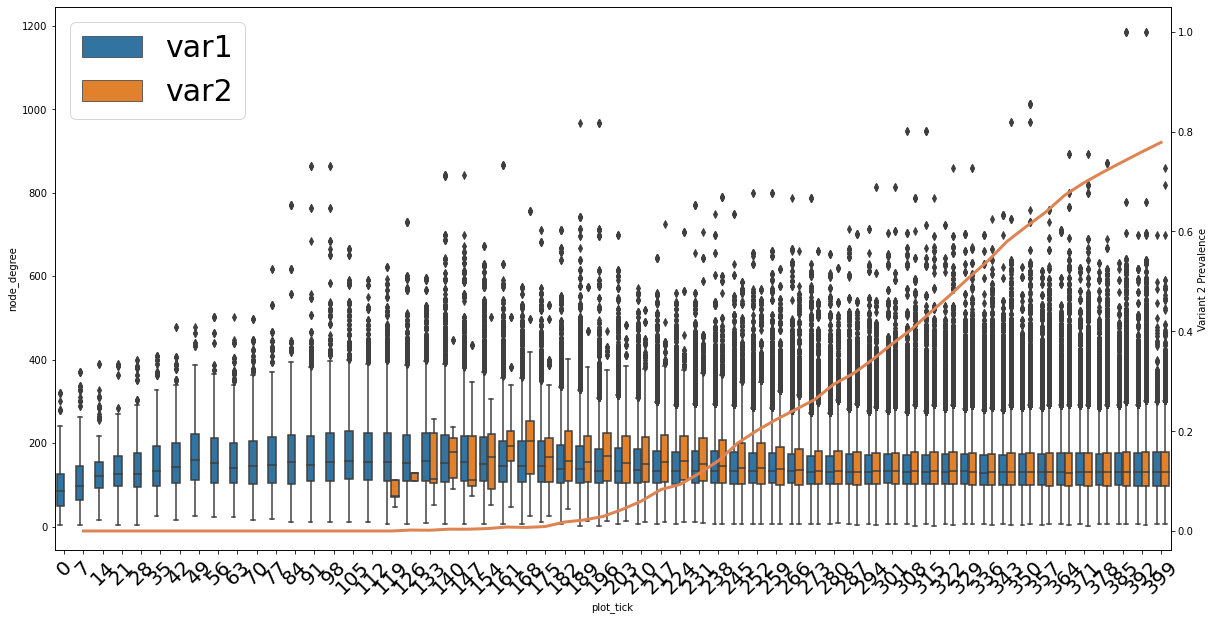

In [10]:

variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
variant_data["plot_tick"] = variant_data.tick.apply(lambda row: 7 * (row // 7))
fig, ax = plt.subplots(figsize=(20,10))
twinx = ax.twinx()
sns.lineplot(x="tick", y="prop_var2", data=weekly_summary, ax=twinx, linewidth=3, color=sns.color_palette("deep")[1])
# twinx.plot(summary.set_index("tick").loc[::7]["prop_var2"])
# sns.violinplot(x="plot_tick", y="node_degree", hue="variant", data=variant_data, split=True, scale="count", inner="quartile", bw=0.2, ax=ax)
sns.boxplot(x="plot_tick", y="node_degree", hue="variant", data=variant_data, ax=ax)
# ax.legend().remove()
ax.tick_params(axis="x", labelsize=20, labelrotation=45)
twinx.set_ylim(top=1.05)
twinx.set_ylabel("Variant 2 Prevalence")
ax.legend(fontsize=30, loc="upper left")

In [8]:
scenarios[6]

'/scratch/jho5ze/bionets/epihiper/data/output/exp5/tau_0.02_var2_1.4_seed2p_51_seed2t_120'

In [21]:
scenario = scenarios[0]
for replicate in replicates:
#     variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
#     variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
#     variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])
# #     variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg))
#     replicate_data.append(variant_data)
#     replicate = replicate.split("/")[-1]
    summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")
#     total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1)
#     summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]"]].sum(axis=1) / total_infected
#     summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1) / total_infected
#     var2s.append(summary[["tick", "prop_var2"]].set_index("tick").iloc[::tick_spread])
    break
summary[["var2Isymp[current]", "var2Iasymp[current]"]].iloc[-1].sum()

9096

Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_2
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_8
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_13
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_15
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_16
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_17
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_19
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_120 replicate_20
Saving to ../plots/exp5/scenario_summary_node_degree_tau_0.02_var2_1.4_seed2p_51059_seed2t_120_all_replicates_boxplot.png
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_150 replicate_2
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_150 replicate_8
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_150 replicate_13
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_150 replicate_15
Passed on  tau_0.02_var2_1.4_seed2p_51059_seed2t_150 replicate_16
Passed on  tau_0.02_var2

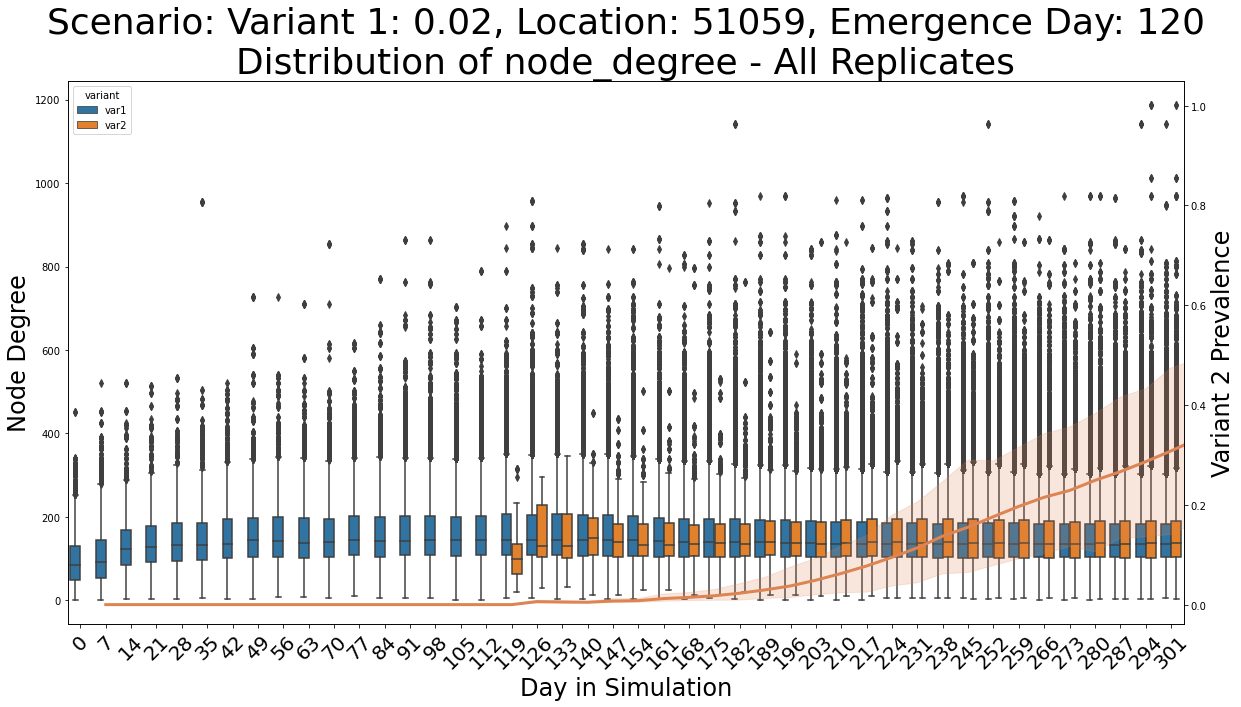

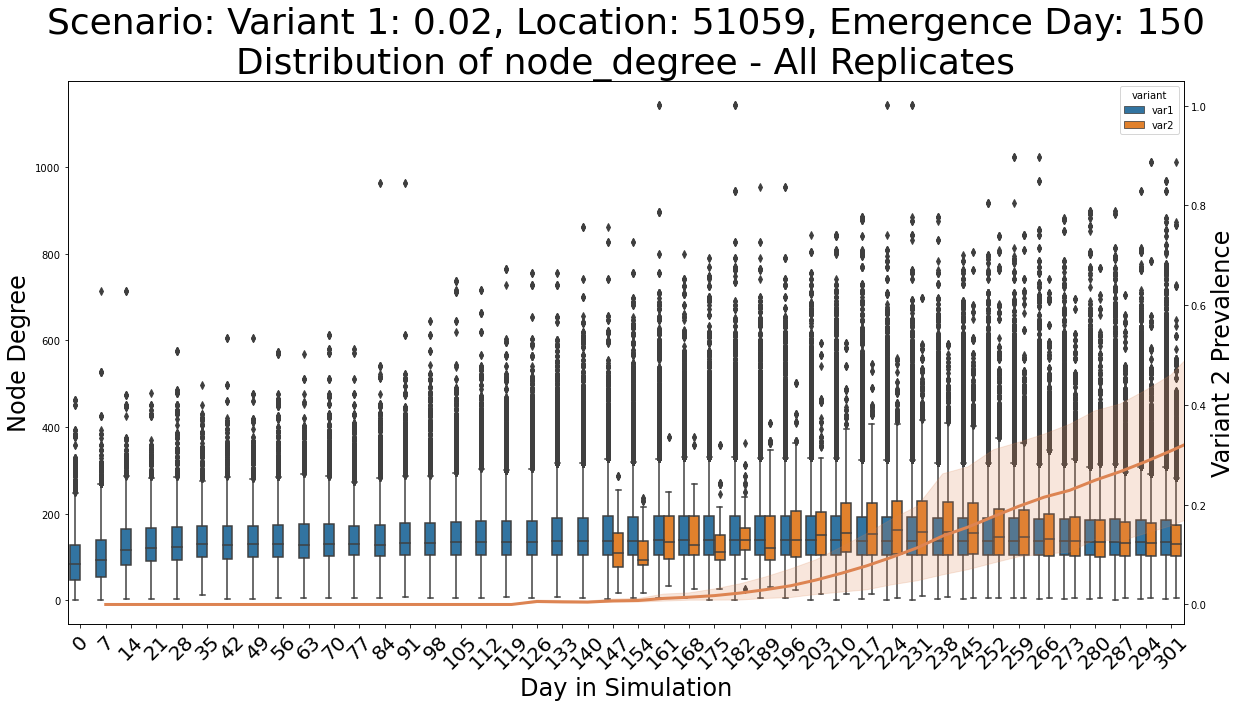

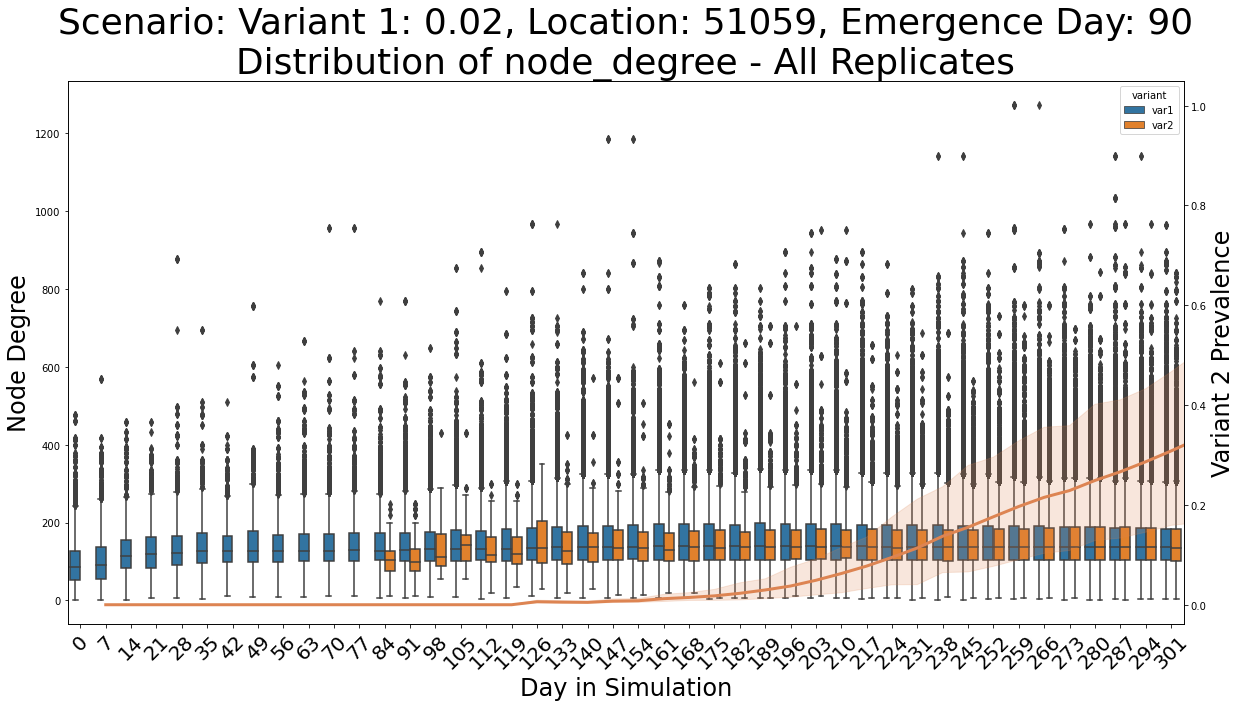

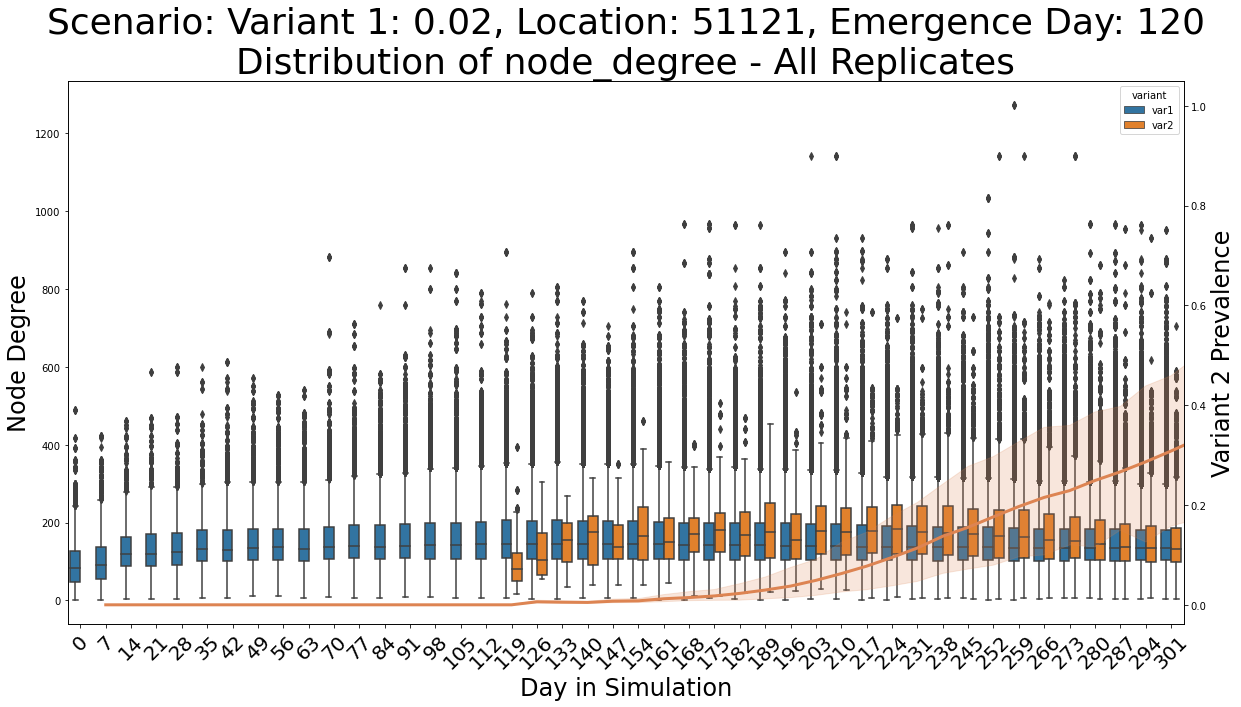

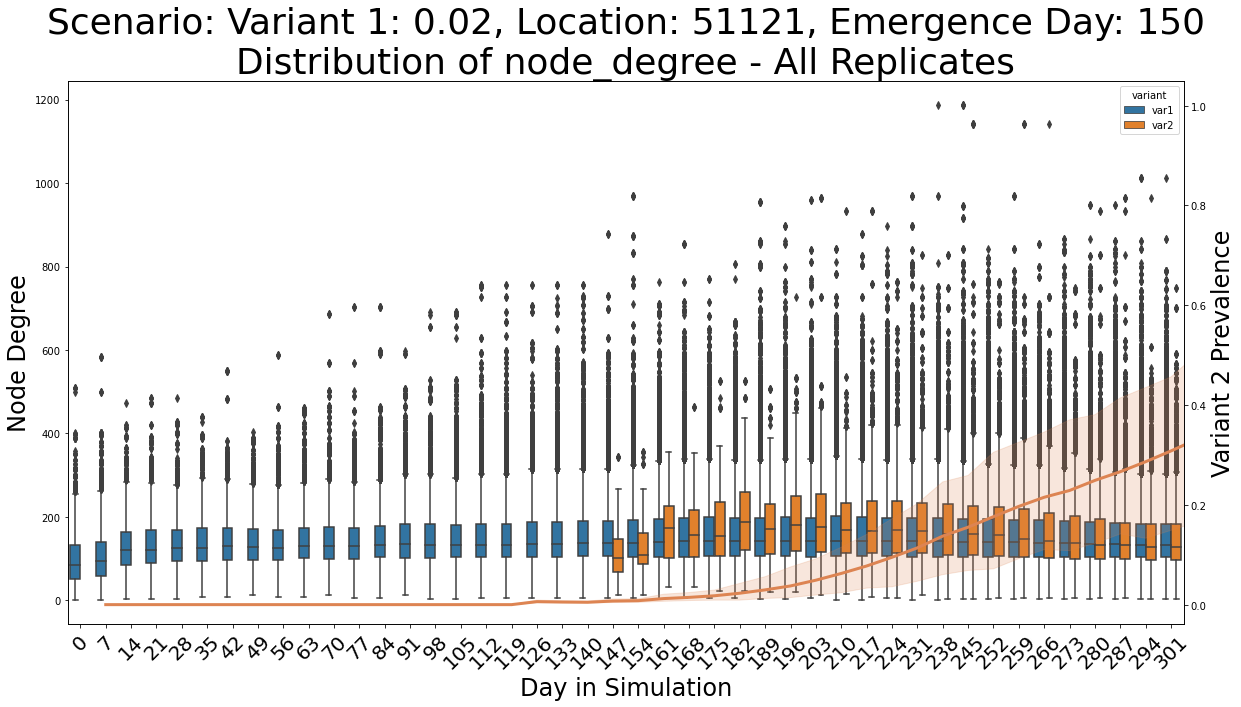

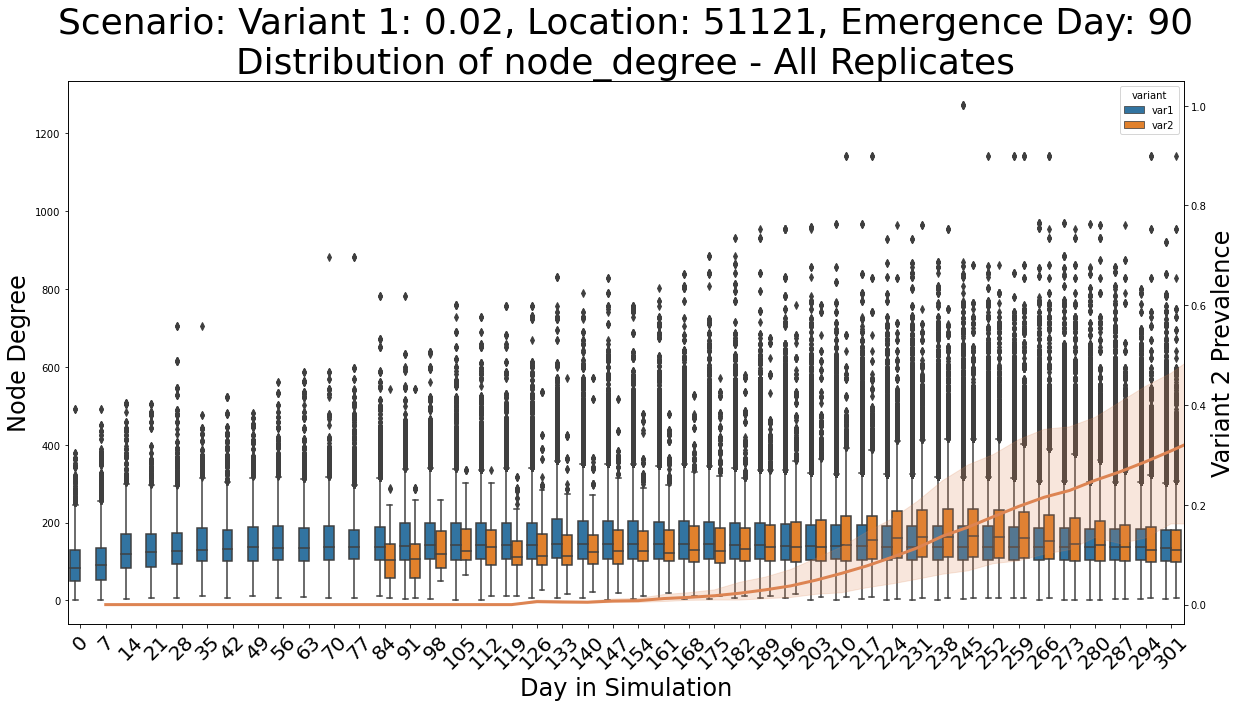

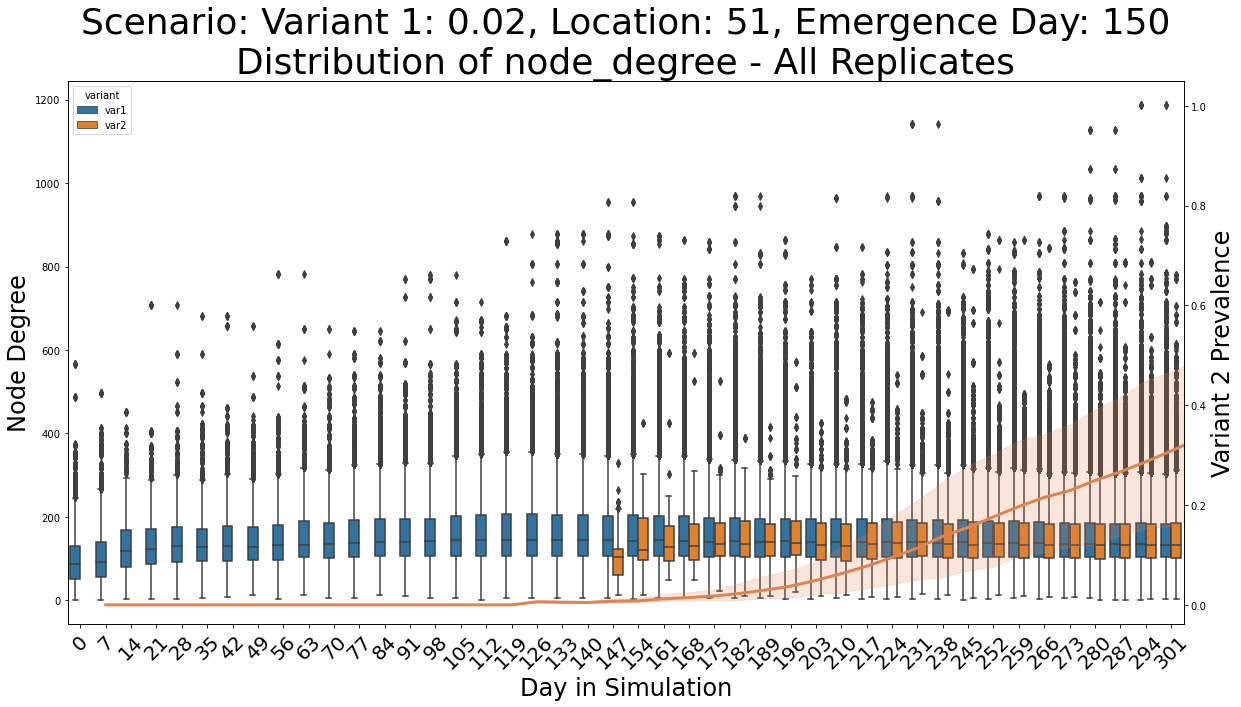

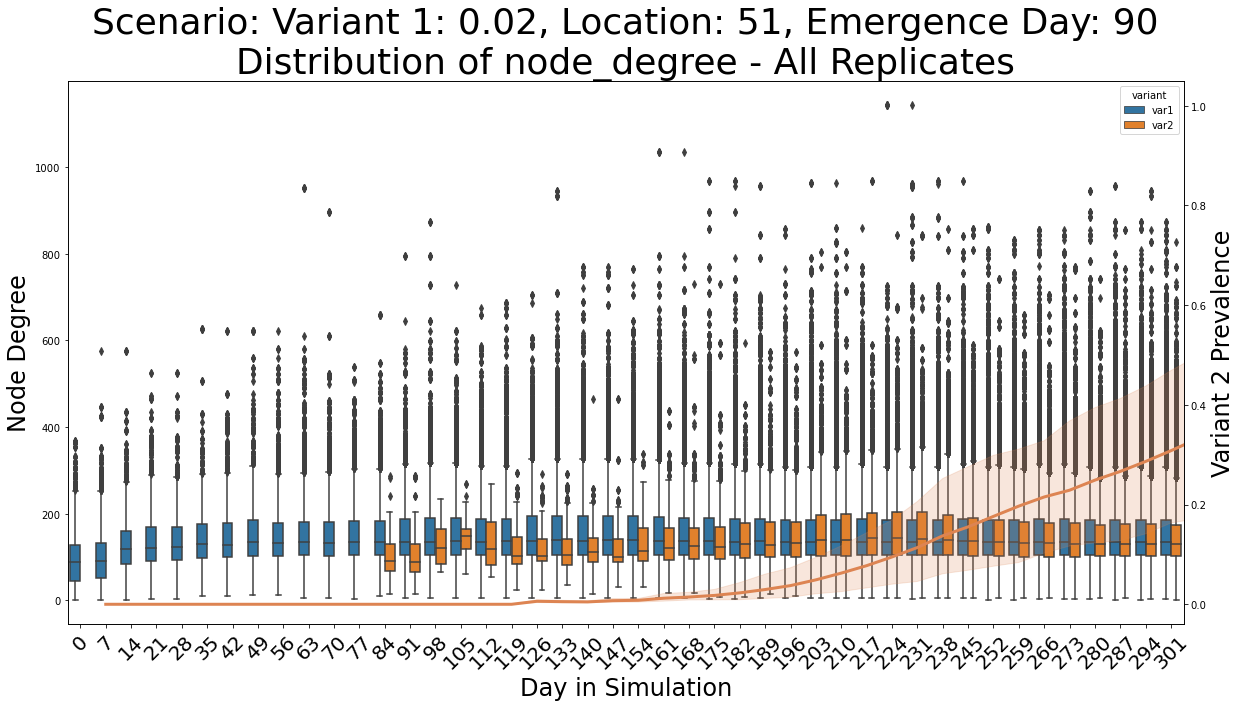

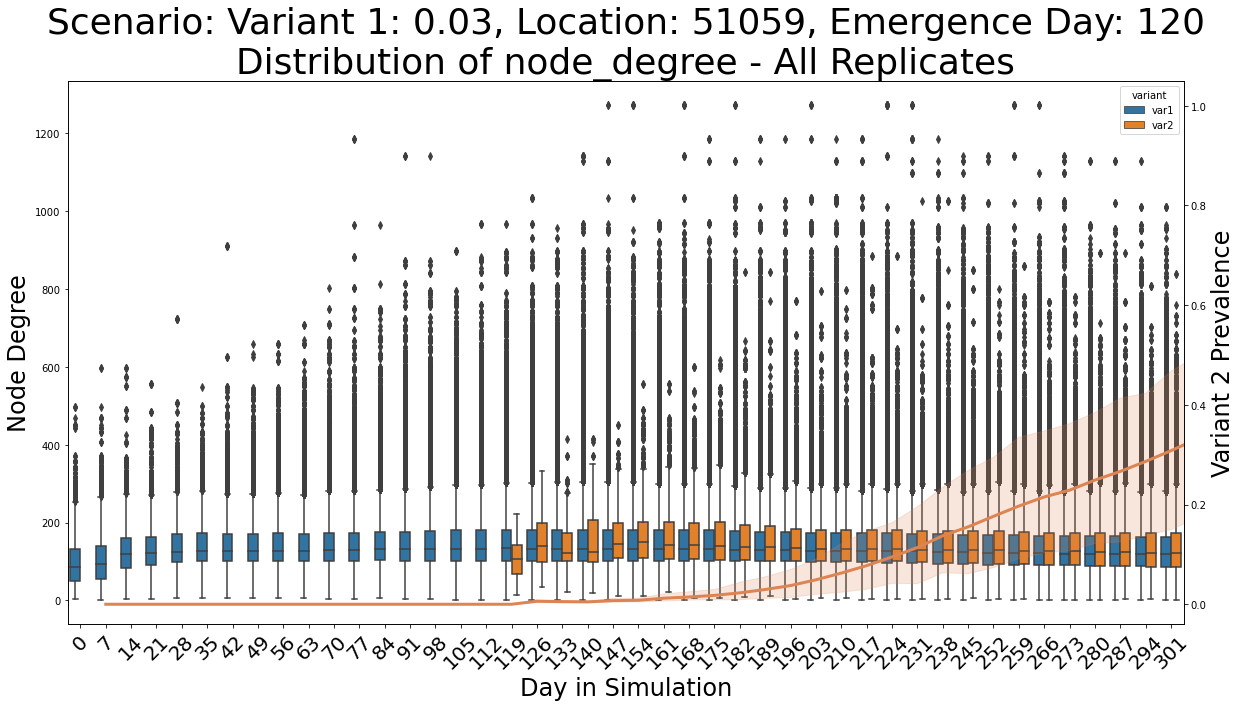

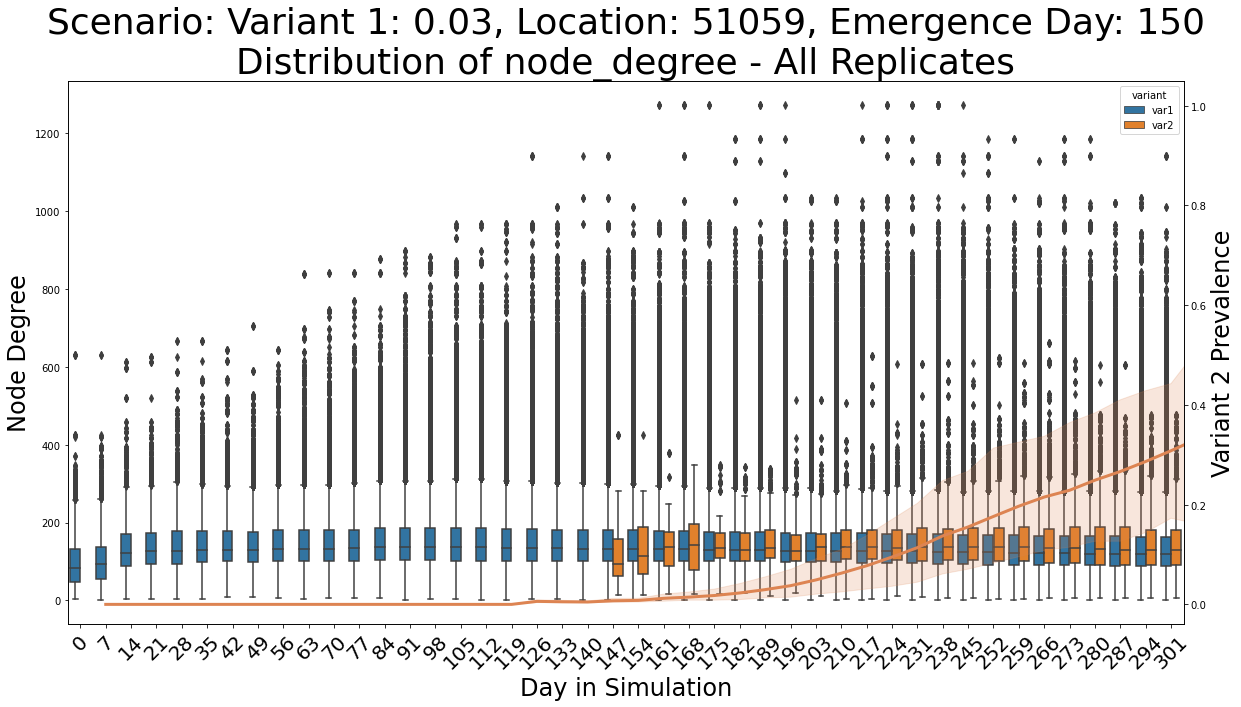

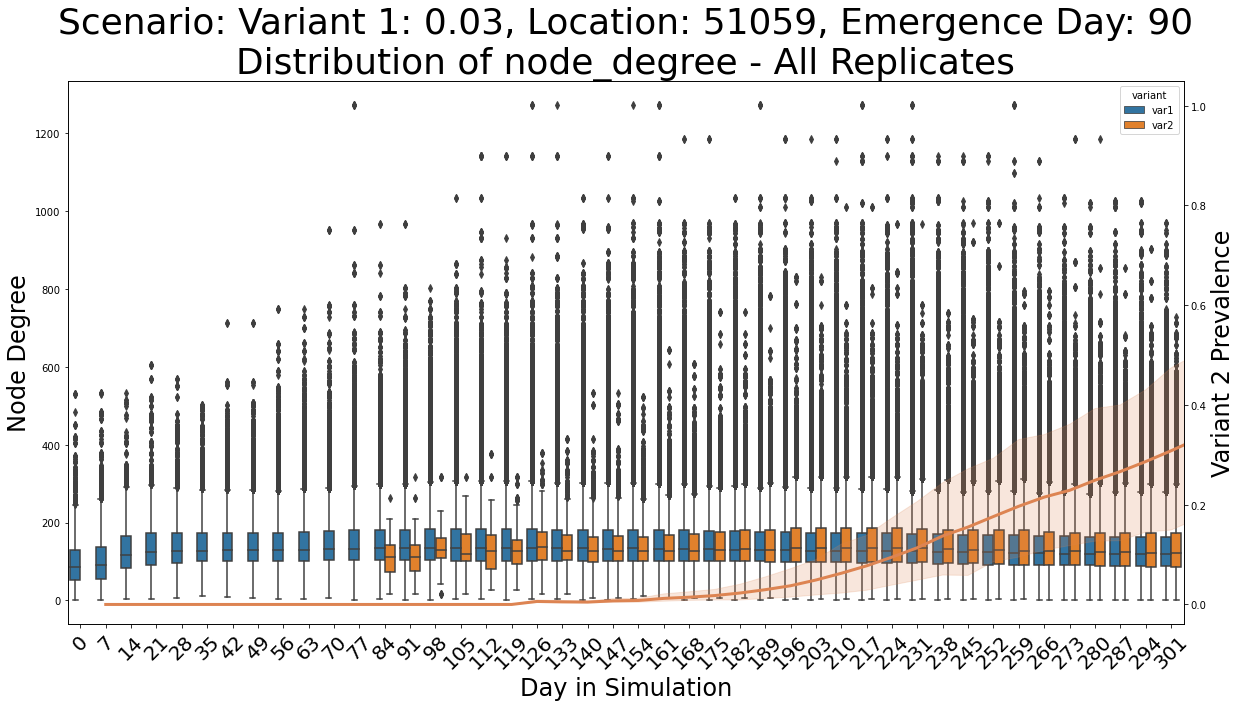

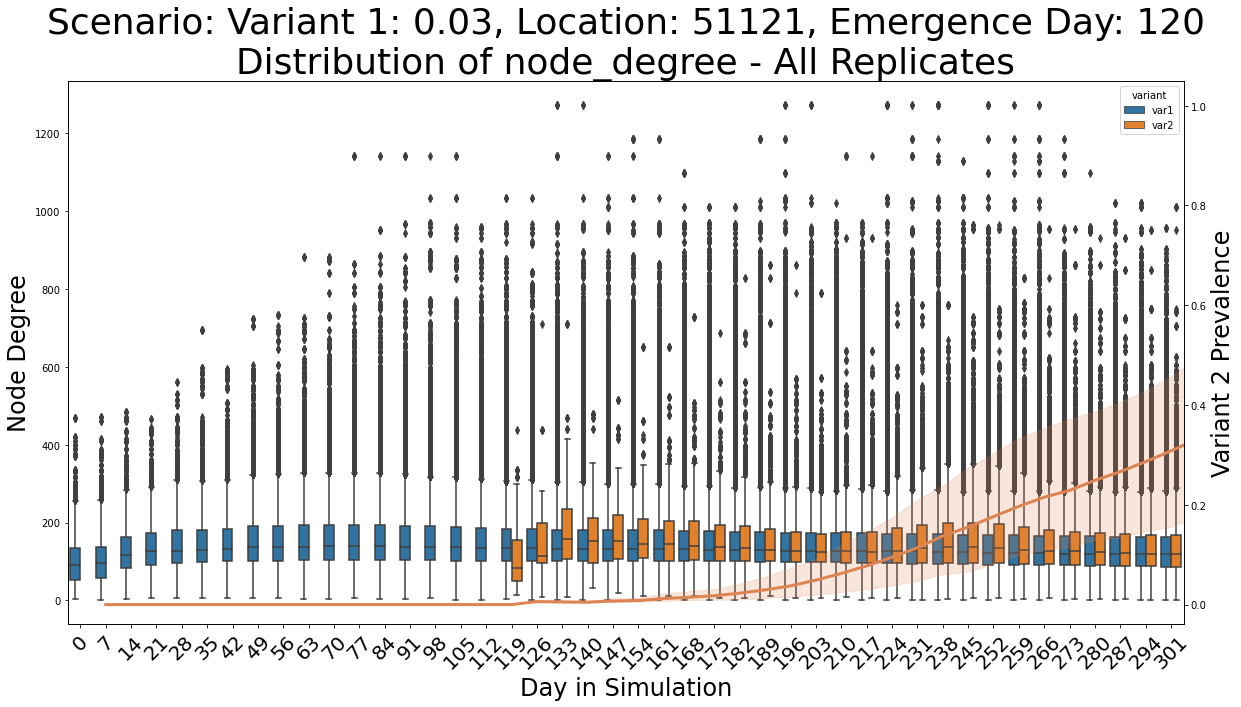

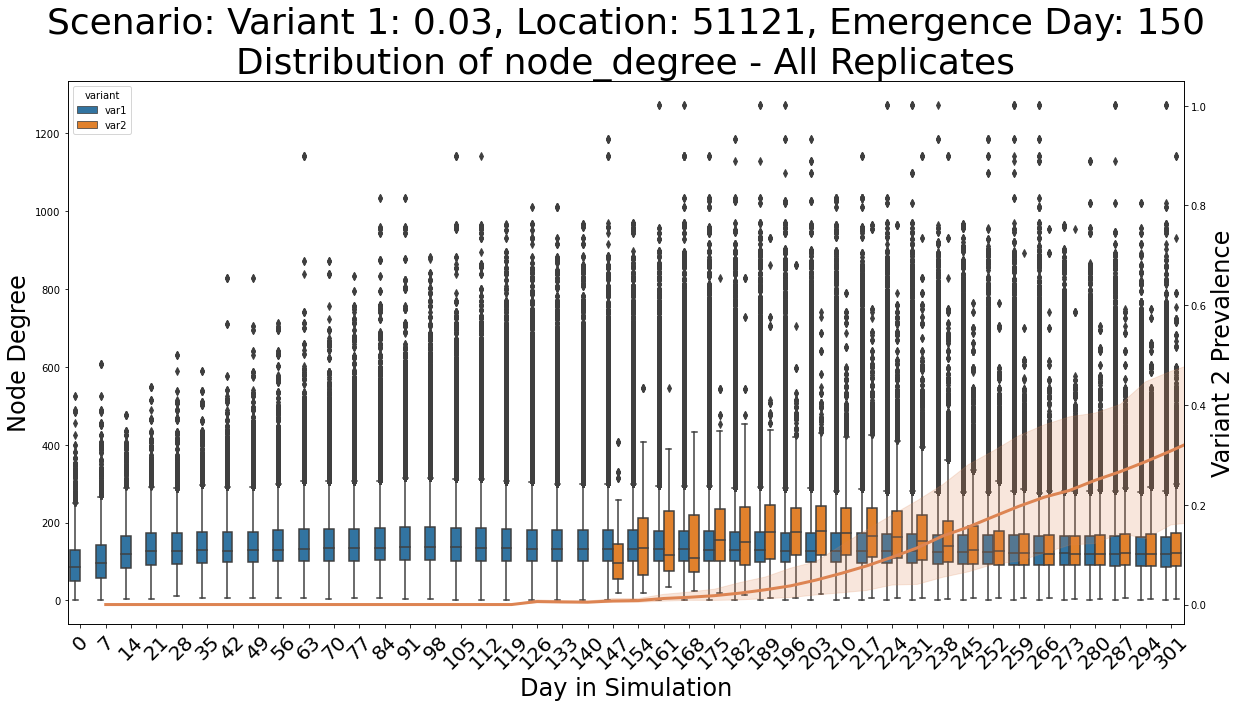

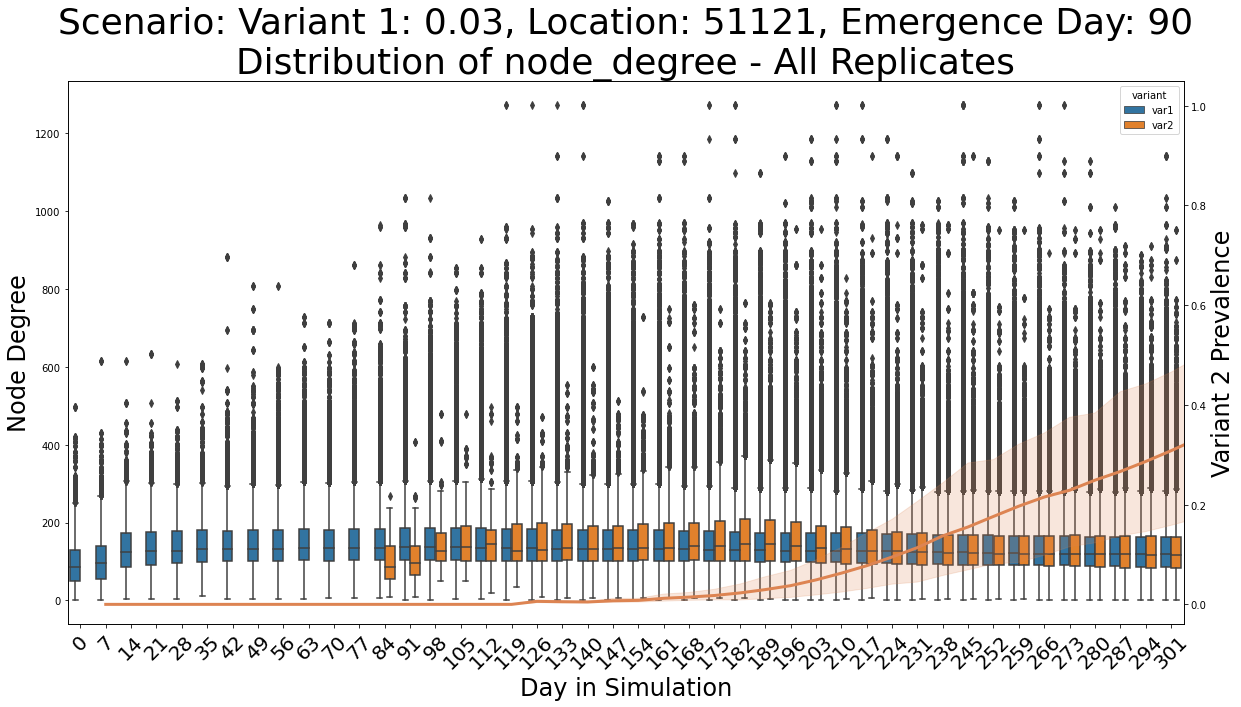

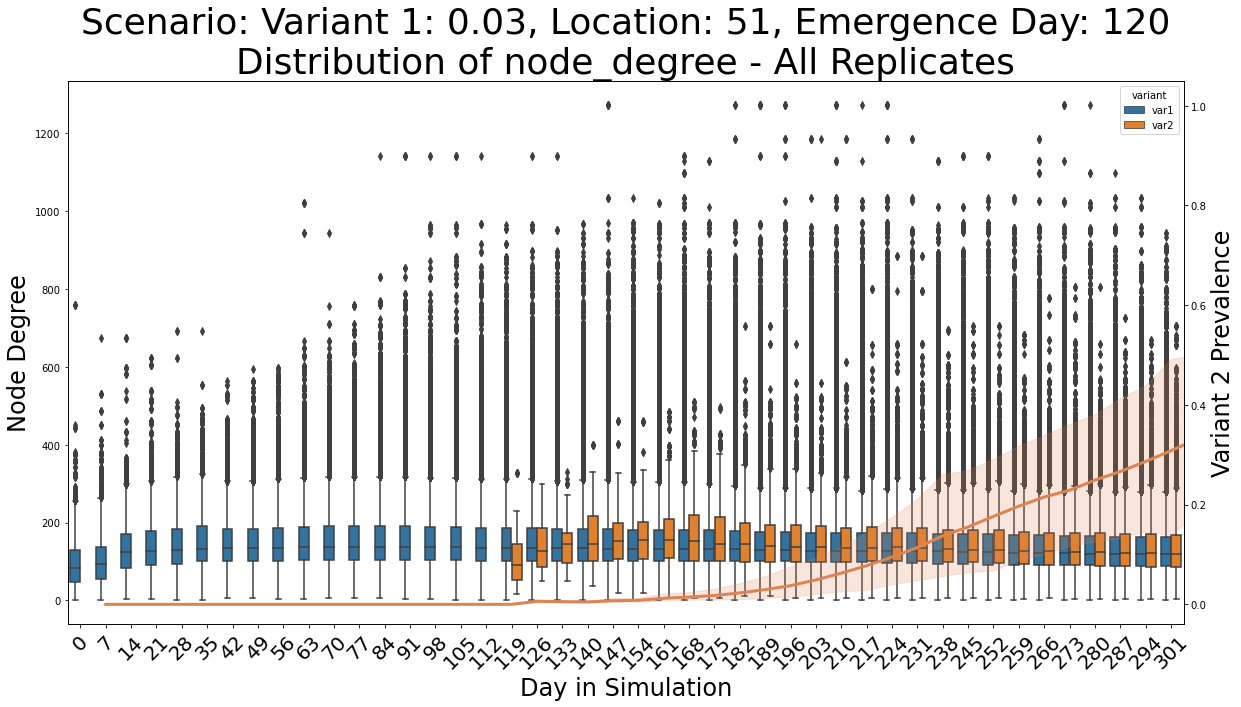

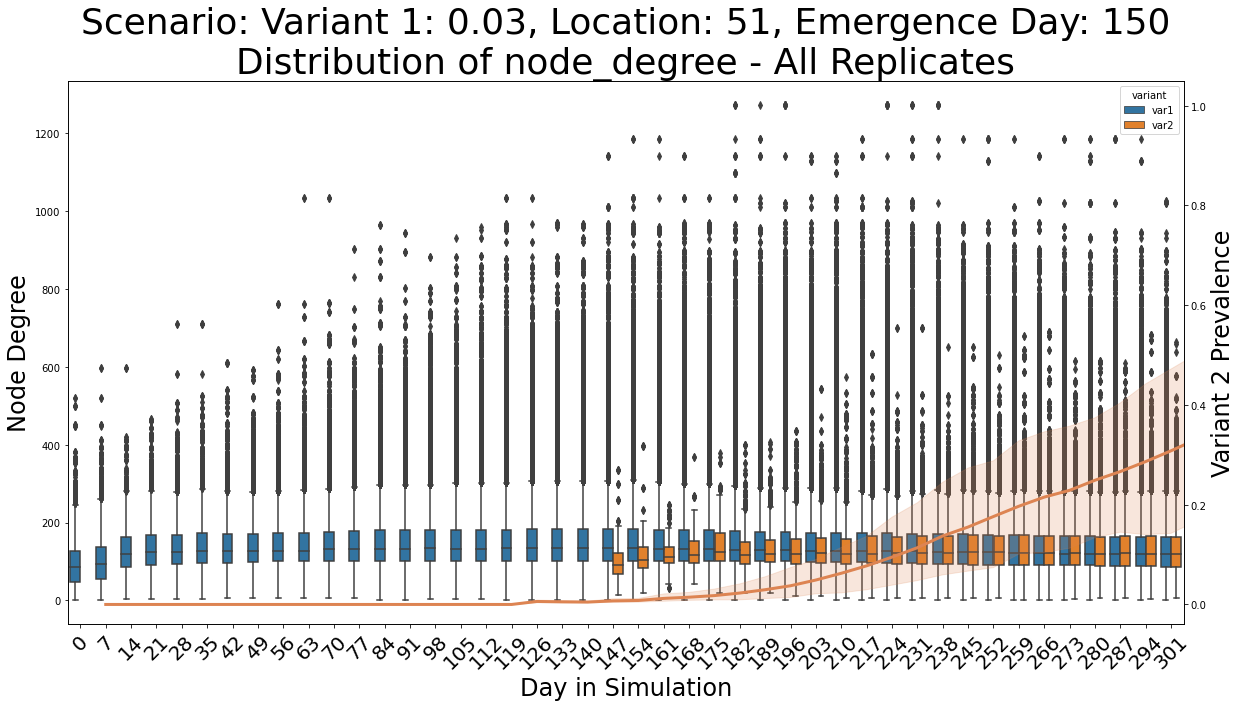

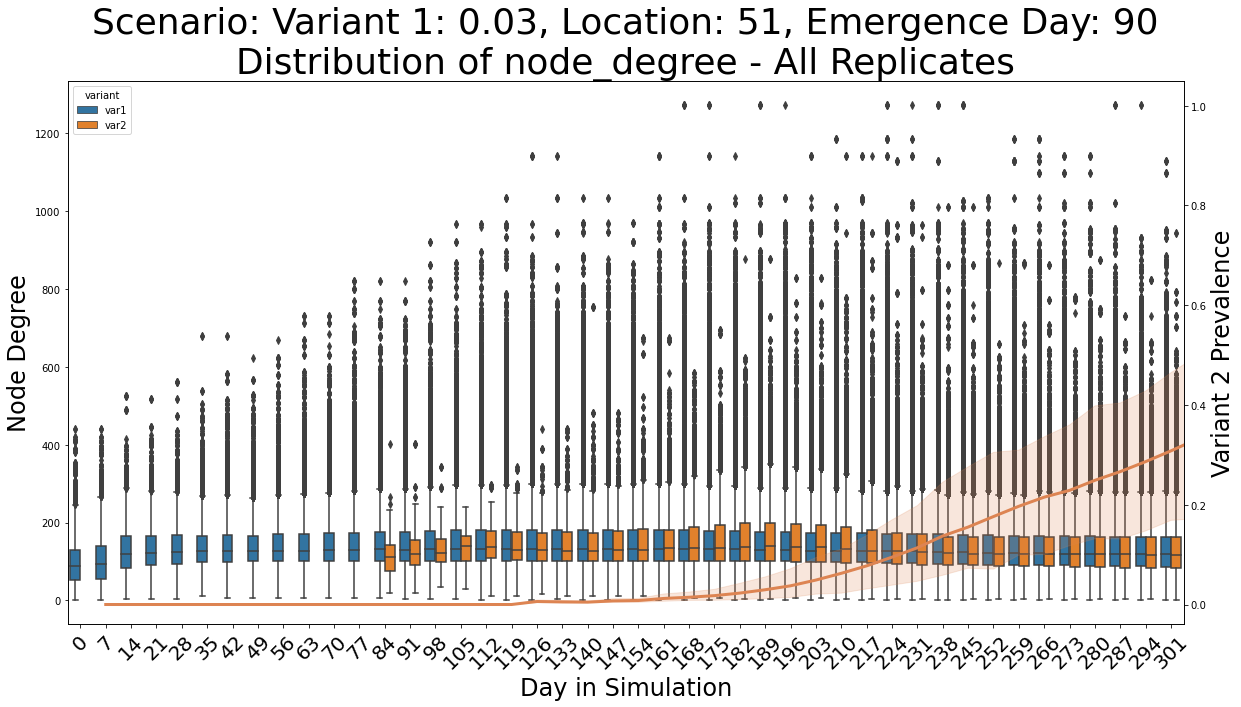

In [29]:
def plot_aggregate_grid(box=False, tick_spread=7, data_col = "node_degree"):
#     fig, axs = plt.subplots(figsize=(120,50), ncols=5, nrows=4)
#     for ix in range(20):
    for ix in range(18):
        if ix == 6:
            continue
        fig, ax = plt.subplots(figsize=(20,10))
                        
#         print(ix)
#         y = ix % 5
#         x = ix // 5
#         ax = axs[x, y]
#         if ix > 17:
#             print(ix)
#             ax.set_visible(False)
#             continue
        scenario = scenarios[ix]
        replicate_data = []
        var2s = []

        for replicate in replicates:
            summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")
            if summary[["var2Isymp[current]", "var2Iasymp[current]"]].iloc[-1].sum() < 1:
                print("Passed on ", scenario.split("/")[-1], replicate.split("/")[-1])
                continue
            variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
            variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
            variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])
        #     variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg))
            replicate_data.append(variant_data)
            replicate = replicate.split("/")[-1]
            total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1)
            summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]"]].sum(axis=1) / total_infected
            summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1) / total_infected
            var2s.append(summary[["tick", "prop_var2"]].set_index("tick").iloc[::tick_spread])
        var2s = pd.concat(var2s) #, axis=1)
        var2s.index = var2s.index.astype(str)

        all_replicates = pd.concat(replicate_data)
        all_replicates["plot_tick"] = all_replicates.tick.apply(lambda row: tick_spread * (row // tick_spread))
        
        twinx = ax.twinx()
        sns.lineplot(data=var2s.reset_index(), x="tick", y="prop_var2", ax=twinx, linewidth=3, color = sns.color_palette("deep")[1], ci=99)
        sns.boxplot(x="plot_tick", y=data_col, hue="variant", data=all_replicates[all_replicates.plot_tick < 302], ax=ax)

        ax.tick_params(axis="x", labelsize=20, labelrotation=45)
        twinx.set_ylim(top=1.05)
        twinx.set_ylabel("Variant 2 Prevalence", fontsize=24)
        ax.set_ylabel("Node Degree", fontsize=24)
        ax.set_xlabel("Day in Simulation", fontsize=24)
        ax.set_title(f"Scenario: {scenario_to_title(scenario)}\nDistribution of {data_col} - All Replicates", fontsize=36)
        scenario = scenario.split("/")[-1]
            
        print(f"Saving to ../plots/{experiment}/scenario_summary_{data_col}_{scenario}_all_replicates_boxplot.png")
        plt.savefig(f"../plots/{experiment}/scenario_summary_{data_col}_{scenario}_all_replicates_boxplot.png", dpi=100, facecolor="white", bbox_inches="tight")

#         break
#     plt.suptitle(f"Distribution of {data_col} Across All Scenarios", y = 0.92, fontsize=46)
#     plt.savefig(f"../plots/{data_col}_all_scenarios_boxplot.png", dpi=100, facecolor="white", bbox_inches="tight")
        
plot_aggregate_grid()

In [86]:
def plot_scenario_grid(scenario, replicate_data, box=False, tick_spread=7, data_col = "node_degree", summary=None):
    fig, axs = plt.subplots(figsize=(120,50), ncols=5, nrows=4)
    box_str = "_box" if box else "_violin"
    for ix in range(20):
        y = ix // 4
        x = ix % 4

        ax = axs[x, y]
        data = replicate_data[ix]
        data["plot_tick"] = data.tick.apply(lambda row: tick_spread * (row // tick_spread))
        if box:
            sns.boxplot(x="plot_tick", y=data_col, hue="variant", data=data, ax=ax)
        else:
            sns.violinplot(x="plot_tick", y=data_col, hue="variant", data=data, split=True, scale="count", inner="quartile", bw=0.2, ax=ax)
            
        if summary is not None:
            weekly_summary = summary.set_index("tick").loc[::tick_spread].reset_index()
            weekly_summary = weekly_summary[weekly_summary.tick.isin(data["plot_tick"].unique())]
            weekly_summary.tick = weekly_summary.tick.astype(str)
            
            twinx = ax.twinx()
            sns.lineplot(x="tick", y="prop_var2", data=weekly_summary, ax=twinx, linewidth=3, color=sns.color_palette("deep")[1])
            twinx.set_ylim(top=1.05)
            twinx.set_ylabel("Variant 2 Prevalence")

        ax.set_title(f"Replicate {ix+1}", fontsize=36)
    plt.suptitle(f"{data_col} for Scenario: {scenario}", y = 0.92, fontsize=46)
    plt.savefig(f"../plots/{data_col}_{scenario}{box_str}.png", dpi=100, facecolor="white", bbox_inches="tight")

In [90]:
replicate_data = []

scenario = scenarios[0].split("/")[-1]
for replicate in replicates:
    variant_data = pd.read_csv(f"../data/processed_{experiment}/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
    variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
    variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])
#     variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg))
    replicate_data.append(variant_data)

In [187]:
var2s = []
for replicate in replicates:
    replicate = replicate.split("/")[-1]
    summary = pd.read_csv(base / experiment / scenario / replicate / "outputSummary.csv.gz")
    total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1)
    summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]"]].sum(axis=1) / total_infected
    summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1) / total_infected
    var2s.append(summary[["tick", "prop_var2"]].set_index("tick").iloc[::7])
var2s = pd.concat(var2s) #, axis=1)
var2s.index = var2s.index.astype(str)
# bounds = pd.DataFrame(var2s.quantile(q = 0.5, axis=1).rename("med"))
# bounds["lower"] = var2s.quantile(q = 0.25, axis=1)
# bounds["upper"] = var2s.quantile(q = 0.75, axis=1)
# bounds = bounds.loc[::7].reset_index()
# # bounds = bounds[bounds.tick.isin(all_replicates["plot_tick"].unique())]
# bounds.tick = bounds.tick.astype(str)
# bounds = bounds.set_index("tick")
# bounds

In [180]:
all_replicates = pd.concat(replicate_data)
all_replicates["plot_tick"] = all_replicates.tick.apply(lambda row: 7 * (row // 7))


In [181]:
all_replicates.head()

pid  tick variant  node_degree  node_age  plot_tick
0  4490178     0    var1          124         9          0
1  5136957     0    var1           30        67          0
2    95876     0    var1           18        74          0
3  1977988     0    var1           56        58          0
4  5955653     0    var1           80        16          0

Text(0.5, 1.0, 'Scenario: tau_0.02_var2_1.4_seed2p_51059_seed2t_120')

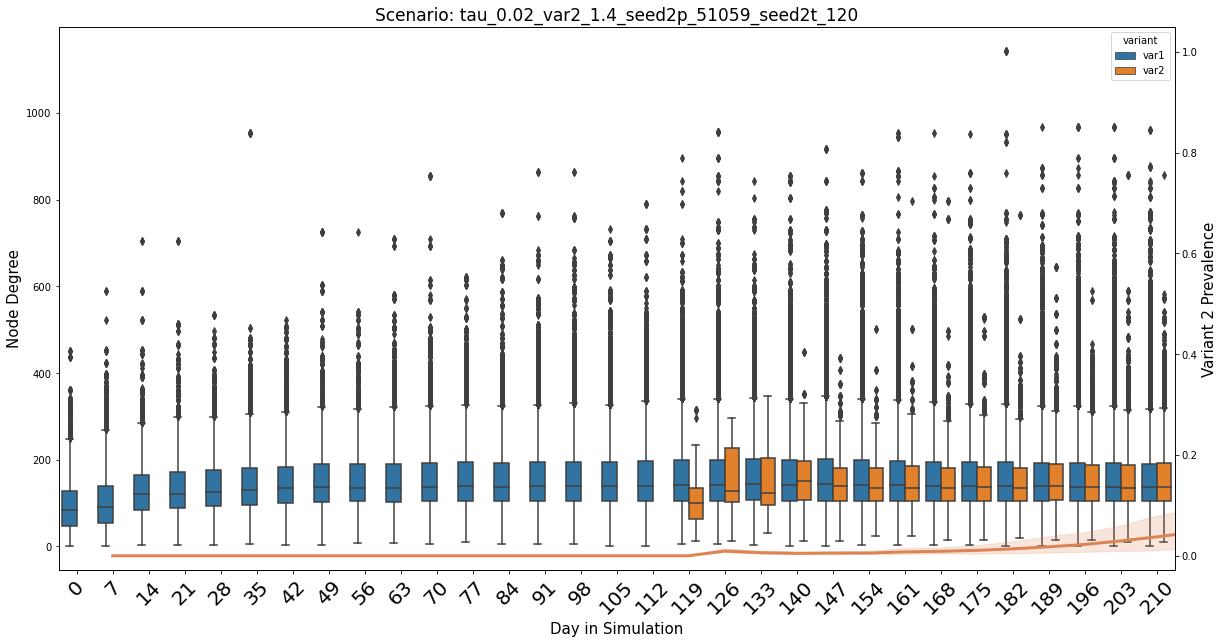

In [195]:
fig, ax = plt.subplots(figsize=(20,10))
twinx = ax.twinx()
sns.lineplot(data=var2s.reset_index(), x="tick", y="prop_var2", ax=twinx, linewidth=3, color = sns.color_palette("deep")[1], ci=99)
# bounds.plot(ax=twinx, linewidth=3, color = sns.color_palette("deep")[1]) 
#sns.lineplot(x="tick", y="prop_var2", data=bounds, ax=twinx, linewidth=3, color=sns.color_palette("deep")[1])
# twinx.plot(summary.set_index("tick").loc[::7]["prop_var2"])
# sns.violinplot(x="plot_tick", y="node_degree", hue="variant", data=variant_data, split=True, scale="count", inner="quartile", bw=0.2, ax=ax)
sns.boxplot(x="plot_tick", y="node_degree", hue="variant", data=all_replicates[all_replicates.plot_tick < 302], ax=ax)
# # ax.legend().remove()

ax.tick_params(axis="x", labelsize=20, labelrotation=45)
twinx.set_ylim(top=1.05)
twinx.set_ylabel("Variant 2 Prevalence", fontsize=15)
ax.set_ylabel("Node Degree", fontsize=15)
ax.set_xlabel("Day in Simulation", fontsize=15)
ax.set_title(f"Scenario: {scenario}", fontsize=17)
# ax.legend(fontsize=30, loc="upper left")

In [ ]:
# for scenario in ["tau_0.02_var2_1.4_seed2p_51059_seed2t_120"]: #scenarios[2:]:
for scenario in scenarios:
    try:
        scenario = scenario.split("/")[-1]
    # scenario = "tau_0.02_var2_1.4_seed2p_51059_seed2t_120"
        replicate_data = []

        for replicate in replicates:
            variant_data = pd.read_csv(f"../data/processed_scenarios/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
            variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
            variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])
        #     variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg))
            replicate_data.append(variant_data)
        plot_scenario(scenario, replicate_data)
        plot_scenario(scenario, replicate_data, data_col="node_age")
        plot_scenario(scenario, replicate_data, box=True)
        plot_scenario(scenario, replicate_data, box=True, data_col="node_age")
    except:
        print(scenario)
        continue
#     break

tau_0.02_var2_1.4_seed2p_51059_seed2t_120


<ipython-input-14-9c466b354ac8>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(120,50), ncols=5, nrows=4)


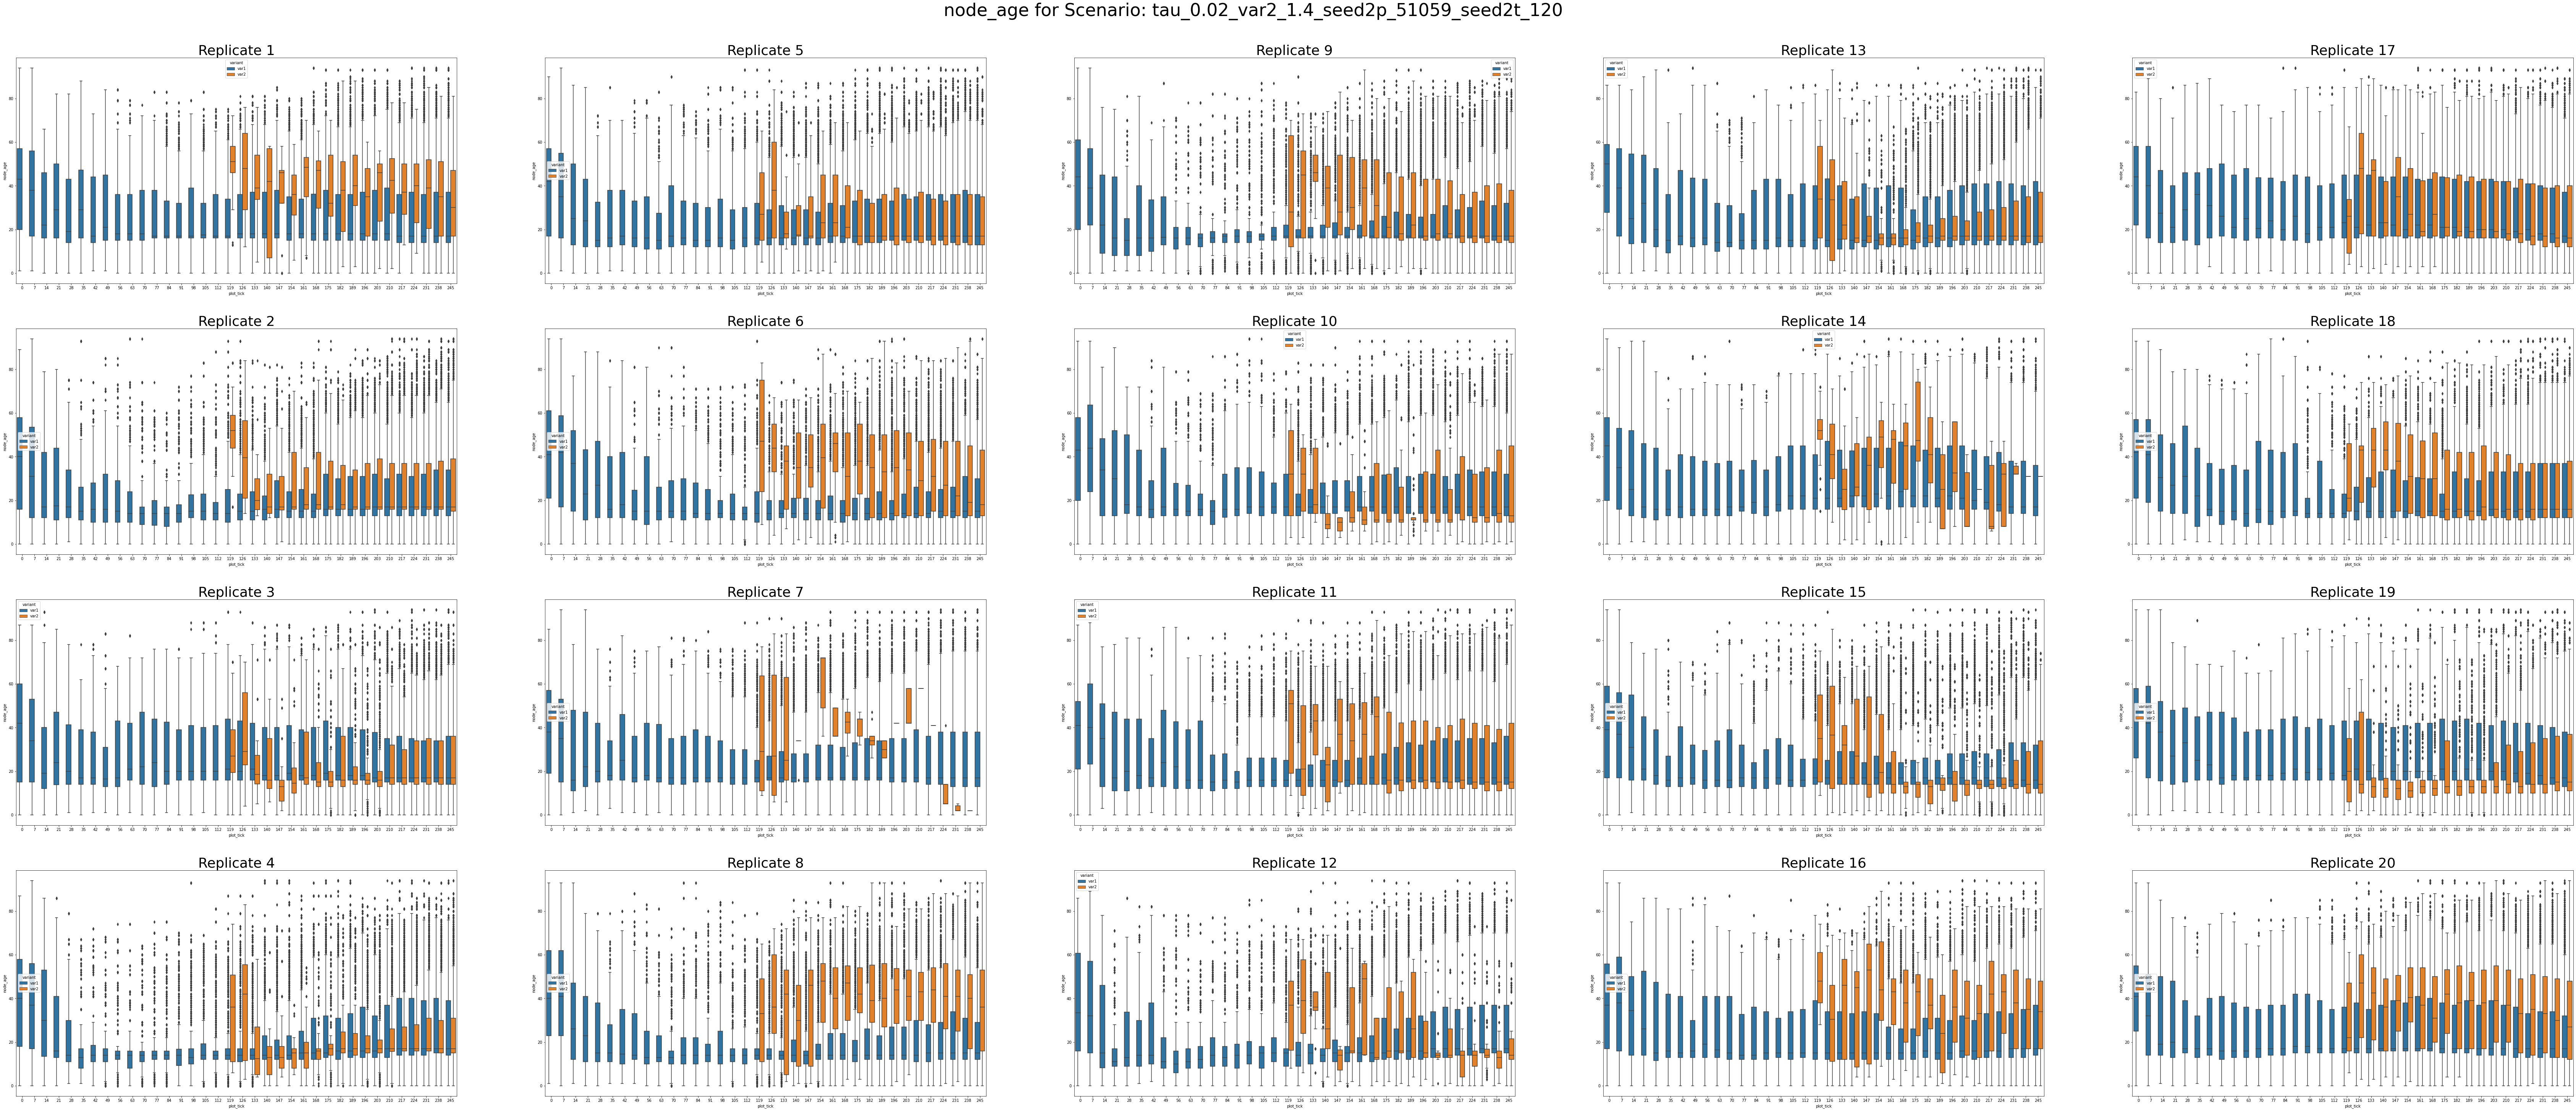

In [15]:

scenario = "tau_0.02_var2_1.4_seed2p_51059_seed2t_120"
replicate_data = []

for replicate in replicates:
    variant_data = pd.read_csv(f"../data/processed_scenarios/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
    variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
    variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])
#     variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg))
    replicate_data.append(variant_data)
plot_scenario(scenario, replicate_data, box=True, data_col="node_age")

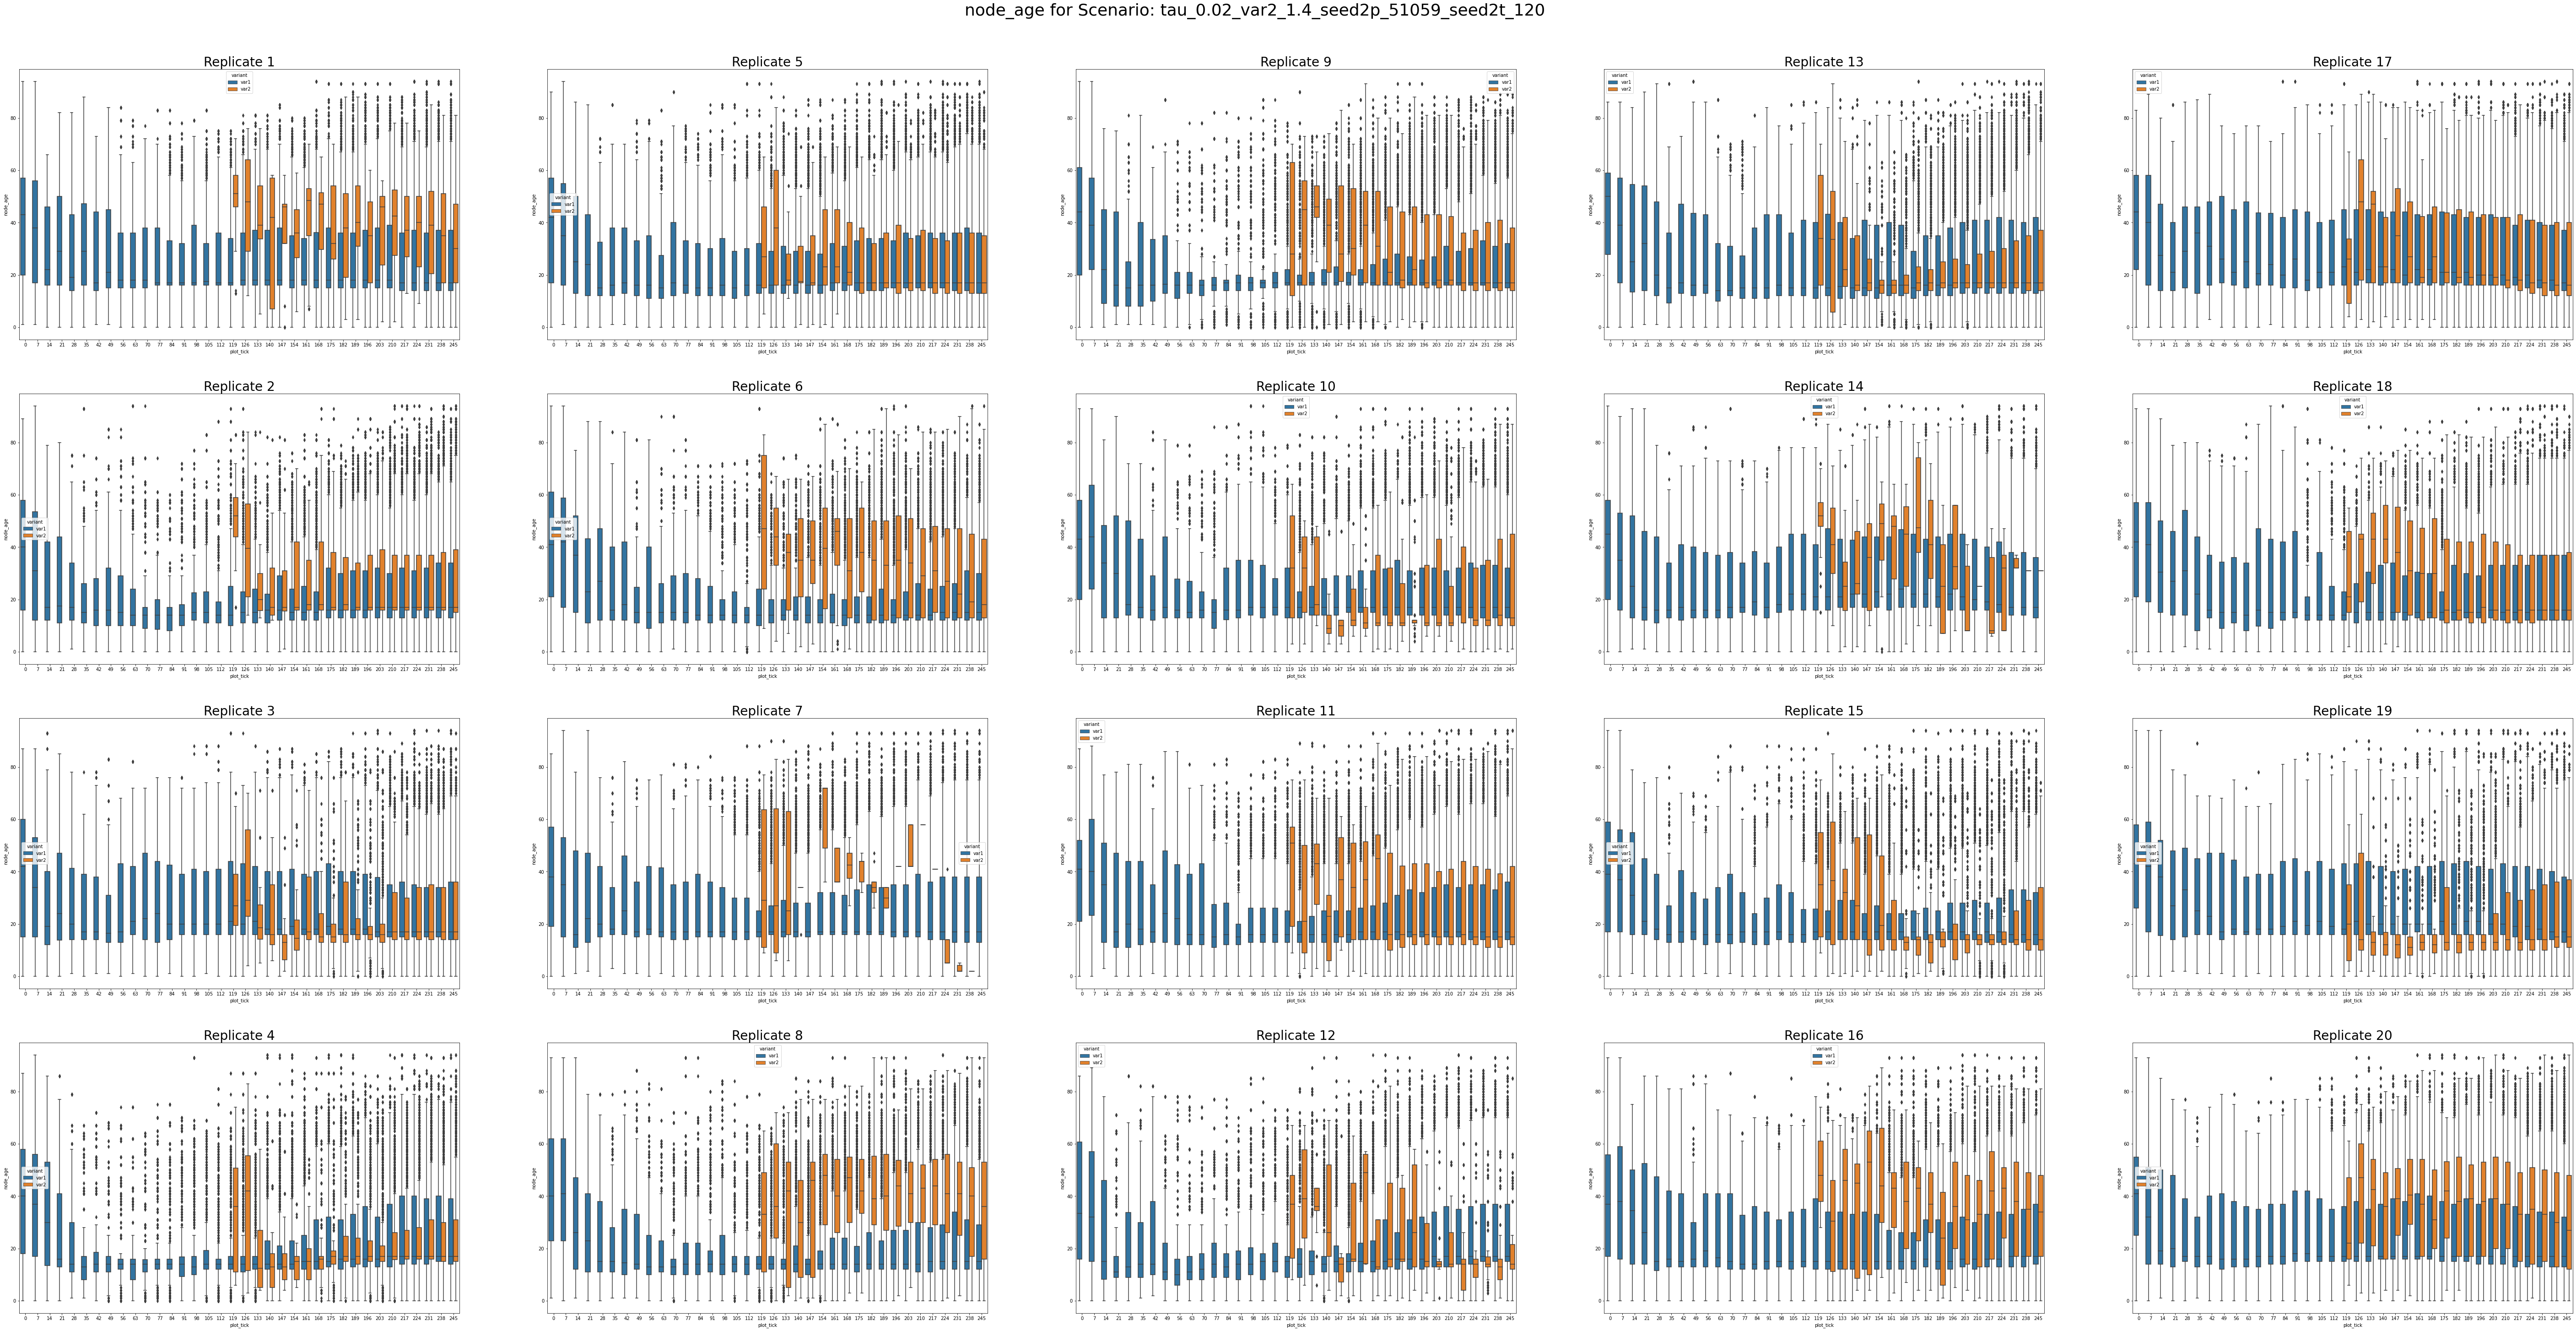

In [10]:

scenario = "tau_0.02_var2_1.4_seed2p_51059_seed2t_120"
replicate_data = []

for replicate in replicates:
    variant_data = pd.read_csv(f"../data/processed_scenarios/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
    variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
    variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])
#     variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg))
    replicate_data.append(variant_data)
plot_scenario(scenario, replicate_data, box=True, data_col="node_age")

In [19]:
# variant_data = pd.read_csv(f"../data/processed_scenarios/{scenario.split('/')[-1]}_{replicate.split('/')[-1]}_variant_data.csv")
# variant_data

In [70]:
variant_data = pd.concat(dfs)
variant_data["node_degree"] = variant_data.pid.apply(lambda row: node_degrees[str(row)])
variant_data["node_age"] = variant_data.pid.apply(lambda row: node_age[row])

day_agg = 7
variant_data["plot_tick"] = variant_data.tick.apply(lambda row: day_agg * (row // day_agg)) #.resample()
# variant_data["date"] = variant_data.tick.apply(lambda row: np.datetime64("2021-01-01") + np.timedelta64(row, "D"))
# variant_data = variant_data.set_index("date")

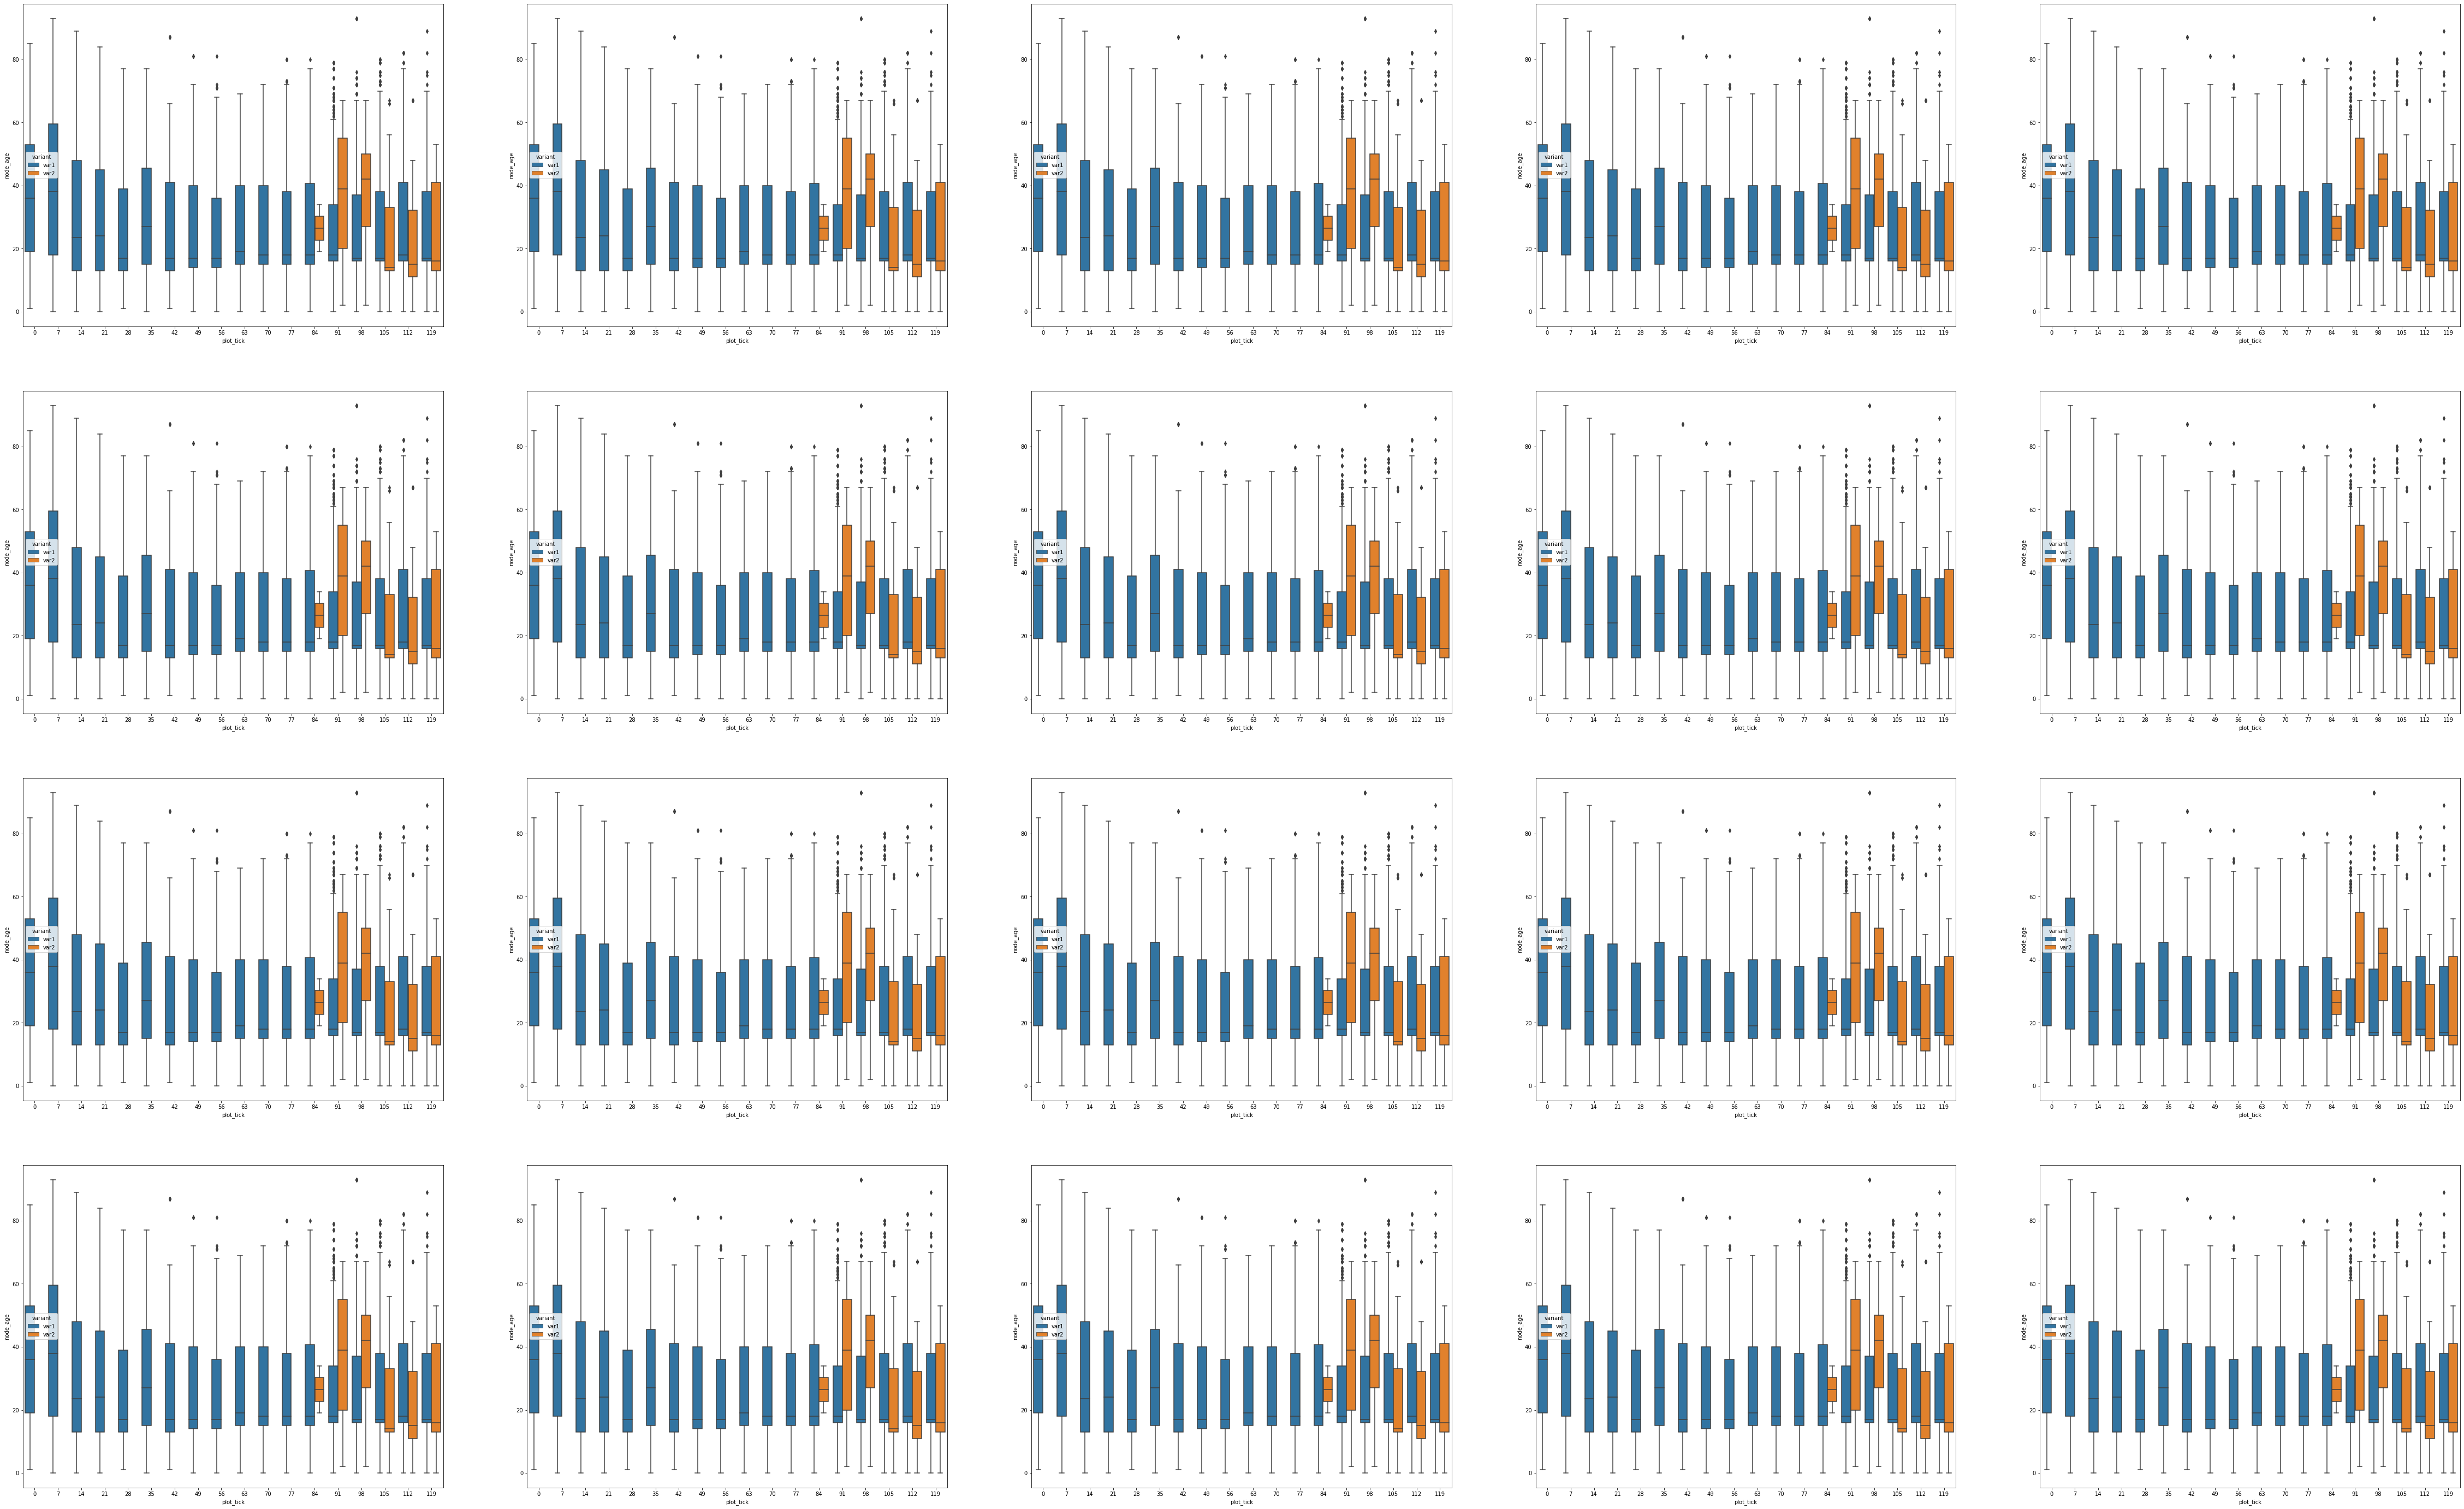

In [72]:
fig, axs = plt.subplots(figsize=(80,50), ncols=5, nrows=4)
for ix in range(20):
    y = ix // 4
    x = ix % 4
    
    ax = axs[x, y]
#     ax.text(0.5, 0.5, f"{x}, {y}")
#     sns.violinplot(x="plot_tick", y="node_degree", hue="variant", data=variant_data, split=True, scale="count", inner="quartile", bw=0.2, ax=ax)
    sns.boxplot(x="plot_tick", y="node_age", hue="variant", data=variant_data, ax=ax)

#### Data Prep

In [13]:
node_ids = [int(i) for i in node_degrees.keys()]
suscep_degrees = node_degrees.copy()
state_array = ["S" for i in range(7688058+1)]
state_dict = {state:[] for state in output.exit_state.unique()}
state_dict["S"] = node_ids
state_dict_array = []
dfs = []
susc_dfs = []
for tick in tqdm(range(120)):
    df = output[output.tick == tick]
    for pid, state in df.set_index("pid")["exit_state"].to_dict().items():
        prev_state = state_array[pid]
        state_array[pid] = state
#         if prev_state != "S":
#         print(tick, pid, prev_state)
        state_dict[prev_state].remove(pid)
        state_dict[state].append(pid)
        if prev_state == "S":
            del suscep_degrees[str(pid)]
            
#     state_dict_copy = state_dict.copy()
#     del state_dict_copy["S"]
#     state_dict_array.append(state_dict_copy)
    
    ds = []
    x = pd.DataFrame(state_dict["var1E"], columns=["pid"])
    x["tick"] = tick
    x["variant"] = "var1"
#     x["node_degree"] = x.pid.apply(lambda row: node_degrees[str(row)])
    ds.append(x)
    x = pd.DataFrame(state_dict["var2E"], columns=["pid"])
    x["tick"] = tick
    x["variant"] = "var2"
#     x["node_degree"] = x.pid.apply(lambda row: node_degrees[str(row)])
    ds.append(x)
    df = pd.concat(ds)
    dfs.append(df)
    
#     x = pd.DataFrame(suscep_degrees.values(), columns=["node_degree"])
#     x["tick"] = tick
#     susc_dfs.append(x)
    
#     break

100%|██████████| 120/120 [02:36<00:00,  1.31s/it]


#### Susceptible plots

In [22]:
suscep_data = pd.concat(susc_dfs)
# suscep_data["node_degree"] = suscep_data.pid.apply(lambda row: node_degrees[str(row)])

In [ ]:
sns.violinplot(x="tick", y="node_degree", data=suscep_data)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:xlabel='tick'>

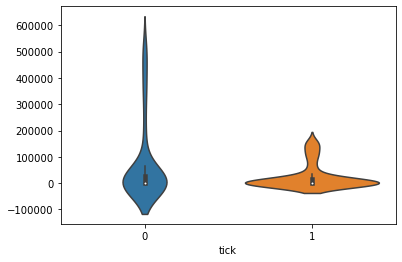

In [53]:
t = suscep_data.head(10000000)
t.node_degree = pd.cut(t.node_degree, range(0, t.node_degree.max()+10, 10), labels=range(0, t.node_degree.max()+10, 10)[:-1])
t = t.groupby("tick").node_degree.value_counts().rename("count").reset_index()
t = t.pivot(index="node_degree", columns="tick", values="count")
sns.violinplot(data=t)

In [58]:
t[0]

node_degree
60      517289.0
70      516964.0
80      504946.0
50      499749.0
90      483745.0
          ...   
1090         1.0
1120         1.0
1140         1.0
1180         1.0
1270         1.0
Name: 0, Length: 106, dtype: float64

In [50]:
ds = []
x = pd.DataFrame(state_dict["S"], columns=["pid"])
x["tick"] = tick
# x["variant"] = "var1"
# x["node_degree"] = x.pid.apply(lambda row: node_degrees[str(row)])
# ds.append(x)
# x = pd.DataFrame(state_dict["var2E"], columns=["pid"])
# x["tick"] = tick
# x["variant"] = "var1"
# x["node_degree"] = x.pid.apply(lambda row: node_degrees[str(row)])
# ds.append(x)
# df = pd.concat(ds)

In [24]:
df

tick      pid exit_state  contact_pid
0      0    53306      var1E           -1
1      0   428696      var1E           -1
2      0   964916      var1E           -1
3      0  1671796      var1E           -1
4      0  2013205      var1E           -1
5      0  2366585      var1E           -1
6      0  2420763      var1E           -1
7      0  2691533      var1E           -1
8      0  3413449      var1E           -1
9      0  3728428      var1E           -1
10     0  3915877      var1E           -1
11     0  4624039      var1E           -1
12     0  4821917      var1E           -1
13     0  5058113      var1E           -1
14     0  5318873      var1E           -1
15     0  5943795      var1E           -1
16     0  6409666      var1E           -1
17     0  6756705      var1E           -1
18     0  7067022      var1E           -1
19     0  7636438      var1E           -1

In [18]:
sns.load_dataset("tips")

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

In [6]:
total_infected = summary[["var1Isymp[current]", "var1Iasymp[current]", "var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1)
summary["prop_var1"] = summary[["var1Isymp[current]", "var1Iasymp[current]"]].sum(axis=1) / total_infected
summary["prop_var2"] = summary[["var2Isymp[current]", "var2Iasymp[current]"]].sum(axis=1) / total_infected

<AxesSubplot:>

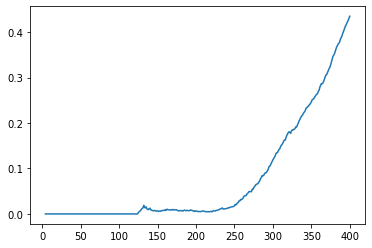

In [8]:
summary.prop_var2.plot()